In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model, IsMovingTarget
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = aff_node.shape[-1] // 2
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

import time 

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False):
    dataset.is_test = False
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = torch.sigmoid(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train a BBNet in rounds

In [5]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(4)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load the motion model for round 0

In [7]:
# motion_path = '../checkpoints/35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
motion_path = '../checkpoints/motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth'
mclass_net = load_model(
                       motion_path,
                       small=False, 
                       cuda=True, 
                       train=False)
mclass_net.module.freeze_bn()
mclass_net.eval()
print(layer_utils.num_parameters(mclass_net))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier
5555009


In [7]:
# ex = 0
# viz_raft_prediction(mclass_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=True, thresh=None)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create a BBNet

In [8]:
bbnet = fprop.BipartiteBootNet(
    motion_params={'hidden_dim': 64, 'num_iters': 12},
    static_params={'hidden_dim': 128, 'num_iters': 12},
    mode='train_static').cuda()

# bbnet_classifier = load_model(
#                        load_path=None,
#                        model_class='motion',
#                        small=True, 
#                        cuda=True, 
#                        train=True)

# bbnet.motion_model = bbnet_classifier
print("num parameters", layer_utils.num_parameters(bbnet))
print("conf weight", bbnet.motion_target_func.confidence_weight)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num parameters 7151208
conf weight False


In [9]:
def get_data(dataset, ex, up_to=2):
    return [x[None] for x in dataset[ex][:up_to]]

def train_step(data, model, optimizer, **kwargs):
    optimizer.zero_grad()
    preds = model(*[x.cuda() for x in data], **kwargs)
    loss = sum(model.loss_list)
    loss.backward()
    optimizer.step()
    target = getattr(model, 'target', None)
    return (data, preds, target, loss)

def eval_step(data, model, teacher=None, mode='val', out_idx=-1, **kwargs):
    model.mode = mode
    if teacher is not None:
        teacher_motion = teacher(*[x.cuda() for x in data], **kwargs)[out_idx].detach()
        data.append(teacher_motion)
    preds = model(*[x.cuda() for x in data], **kwargs)
    return (data, preds)

def train_with_teacher(dataloader, model, teacher, mode='train_static',
                       lr=0.0003, num_steps=100, print_every=5, plot_every=100, out_idx=-1,
                       teacher_iters=1, weight_decay=0.0001,
                       load_path=None, save_path=None,
                       **kwargs):
    
    if load_path is not None:
        did_load = model.load_state_dict(torch.load(load_path), strict=False)
        print("loaded %s, %s" % (load_path, did_load))
        
    model.train()
    model.mode = mode
    if mode == 'train_static':
        optimizer = torch.optim.AdamW(model.static_model.parameters(), 
                                      lr=lr, weight_decay=weight_decay, eps=1e-8)
    elif mode == 'train_motion':
        optimizer = torch.optim.AdamW(model.motion_model.parameters(), 
                                      lr=lr, weight_decay=weight_decay, eps=1e-8)
    loss_curve = []
    step, epoch, running_loss = 0, 0, 0.0
    while (step <= num_steps):
        epoch += 1
        for _step, data in enumerate(dataloader):
            data = data[:2]
            teacher_motion = eval_step(data, teacher, test_mode=True, iters=teacher_iters)[-1][out_idx].detach()
            data.append(teacher_motion)
            loss = train_step(data, model, optimizer, **kwargs)[-1]
            loss_curve.append(loss.item())
            running_loss += (loss.item()) / print_every
        
            if (step % print_every) == 0:
                print("%s w teacher epoch %d / step %d ---- loss %.3f" % (model.mode, epoch-1, _step, running_loss))
                running_loss = 0.0
                
            if (step % plot_every) == 0:
                plt.plot(loss_curve)
                plt.show()
                
            step += 1            
            if step >= num_steps:
                break
            
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print("saved model weights to %s" % save_path)
        
    return loss_curve

def train_selfsup(dataloader, model, mode='train_motion',
                  num_steps=100, print_every=5, plot_every=100, lr=0.0003, weight_decay=0.0001,
                  load_path=None, save_path=None,
                  **kwargs):
    
    if load_path is not None:
        did_load = model.load_state_dict(torch.load(load_path), strict=False)
        print("loaded %s, %s" % (load_path, did_load))    
    
    model.train()
    assert mode in ['train_static', 'train_motion', 'train_both'], mode
    model.mode = mode
    if mode == 'train_motion':
        params = model.motion_model.parameters()
    elif mode == 'train_static':
        params = model.static_model.parameters()
    elif mode == 'train_both':
        params = model.parameters()
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay, eps=1e-8)
    loss_curve = []
    step, epoch, running_loss = 0, 0, 0.0
    while (step <= num_steps):
        epoch += 1
        for _step, data in enumerate(dataloader):
            data = data[:2]
            loss = train_step(data, model, optimizer, **kwargs)[-1]
            loss_curve.append(loss.item())
            running_loss += (loss.item()) / print_every
        
            if (step % print_every) == 0:
                print("%s epoch %d / step %d ---- loss %.3f" % (model.mode, epoch-1, _step, running_loss))
                running_loss = 0.0
                
            if (step % plot_every) == 0:
                plt.plot(loss_curve)
                plt.show()                
                
            step += 1
            if step >= num_steps:
                break
            
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print("saved model weights to %s" % save_path)
            
    return loss_curve    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loaded ../checkpoints/bbnet_split4full_rnd0static_ep20.pth, <All keys matched successfully>
train_motion w teacher epoch 0 / step 0 ---- loss 0.776


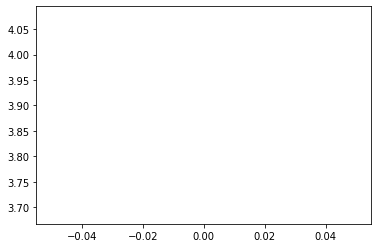

train_motion w teacher epoch 0 / step 5 ---- loss 1.374
train_motion w teacher epoch 0 / step 10 ---- loss 0.993
train_motion w teacher epoch 0 / step 15 ---- loss 0.385
train_motion w teacher epoch 0 / step 20 ---- loss 0.287
train_motion w teacher epoch 0 / step 25 ---- loss 1.508
train_motion w teacher epoch 0 / step 30 ---- loss 0.608
train_motion w teacher epoch 0 / step 35 ---- loss 0.310
train_motion w teacher epoch 0 / step 40 ---- loss 0.581
train_motion w teacher epoch 0 / step 45 ---- loss 0.358
train_motion w teacher epoch 0 / step 50 ---- loss 0.794
train_motion w teacher epoch 0 / step 55 ---- loss 0.507
train_motion w teacher epoch 0 / step 60 ---- loss 0.736
train_motion w teacher epoch 0 / step 65 ---- loss 0.879
train_motion w teacher epoch 0 / step 70 ---- loss 0.861
train_motion w teacher epoch 0 / step 75 ---- loss 0.675
train_motion w teacher epoch 0 / step 80 ---- loss 0.450
train_motion w teacher epoch 0 / step 85 ---- loss 0.593
train_motion w teacher epoch 0 /

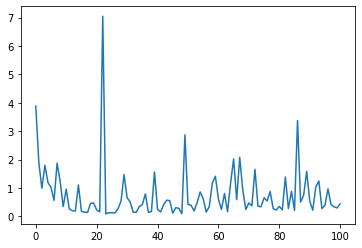

train_motion w teacher epoch 0 / step 105 ---- loss 1.241
train_motion w teacher epoch 0 / step 110 ---- loss 0.465
train_motion w teacher epoch 0 / step 115 ---- loss 0.383
train_motion w teacher epoch 0 / step 120 ---- loss 0.789
train_motion w teacher epoch 0 / step 125 ---- loss 1.426
train_motion w teacher epoch 0 / step 130 ---- loss 0.329
train_motion w teacher epoch 0 / step 135 ---- loss 0.550
train_motion w teacher epoch 0 / step 140 ---- loss 0.377
train_motion w teacher epoch 0 / step 145 ---- loss 0.335
train_motion w teacher epoch 0 / step 150 ---- loss 1.120
train_motion w teacher epoch 0 / step 155 ---- loss 0.706
train_motion w teacher epoch 0 / step 160 ---- loss 0.310
train_motion w teacher epoch 0 / step 165 ---- loss 0.306
train_motion w teacher epoch 0 / step 170 ---- loss 1.141
train_motion w teacher epoch 0 / step 175 ---- loss 0.543
train_motion w teacher epoch 0 / step 180 ---- loss 0.773
train_motion w teacher epoch 0 / step 185 ---- loss 0.331
train_motion w

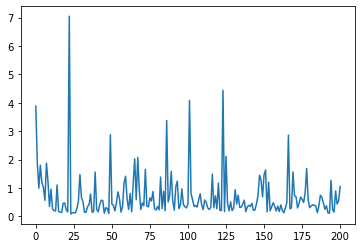

train_motion w teacher epoch 0 / step 205 ---- loss 0.594
train_motion w teacher epoch 0 / step 210 ---- loss 0.849
train_motion w teacher epoch 0 / step 215 ---- loss 0.689
train_motion w teacher epoch 0 / step 220 ---- loss 0.635
train_motion w teacher epoch 0 / step 225 ---- loss 0.356
train_motion w teacher epoch 0 / step 230 ---- loss 0.468
train_motion w teacher epoch 0 / step 235 ---- loss 0.333
train_motion w teacher epoch 0 / step 240 ---- loss 0.724
train_motion w teacher epoch 0 / step 245 ---- loss 0.512
train_motion w teacher epoch 0 / step 250 ---- loss 0.573
train_motion w teacher epoch 0 / step 255 ---- loss 0.825
train_motion w teacher epoch 0 / step 260 ---- loss 0.461
train_motion w teacher epoch 0 / step 265 ---- loss 0.771
train_motion w teacher epoch 0 / step 270 ---- loss 1.205
train_motion w teacher epoch 0 / step 275 ---- loss 0.753
train_motion w teacher epoch 0 / step 280 ---- loss 0.551
train_motion w teacher epoch 0 / step 285 ---- loss 0.735
train_motion w

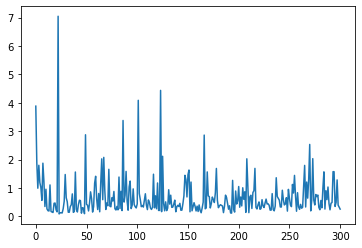

train_motion w teacher epoch 0 / step 305 ---- loss 0.381
train_motion w teacher epoch 0 / step 310 ---- loss 1.220
train_motion w teacher epoch 0 / step 315 ---- loss 2.955
train_motion w teacher epoch 0 / step 320 ---- loss 0.678
train_motion w teacher epoch 0 / step 325 ---- loss 1.210
train_motion w teacher epoch 0 / step 330 ---- loss 1.102
train_motion w teacher epoch 0 / step 335 ---- loss 0.985
train_motion w teacher epoch 0 / step 340 ---- loss 0.467
train_motion w teacher epoch 0 / step 345 ---- loss 2.039
train_motion w teacher epoch 0 / step 350 ---- loss 0.631
train_motion w teacher epoch 0 / step 355 ---- loss 0.566
train_motion w teacher epoch 0 / step 360 ---- loss 0.633
train_motion w teacher epoch 0 / step 365 ---- loss 0.463
train_motion w teacher epoch 0 / step 370 ---- loss 0.554
train_motion w teacher epoch 0 / step 375 ---- loss 1.359
train_motion w teacher epoch 0 / step 380 ---- loss 0.593
train_motion w teacher epoch 0 / step 385 ---- loss 0.921
train_motion w

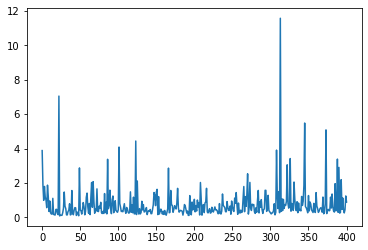

train_motion w teacher epoch 0 / step 405 ---- loss 0.536
train_motion w teacher epoch 0 / step 410 ---- loss 1.060
train_motion w teacher epoch 0 / step 415 ---- loss 0.544
train_motion w teacher epoch 0 / step 420 ---- loss 0.390
train_motion w teacher epoch 0 / step 425 ---- loss 0.918
train_motion w teacher epoch 0 / step 430 ---- loss 0.431
train_motion w teacher epoch 0 / step 435 ---- loss 0.491
train_motion w teacher epoch 0 / step 440 ---- loss 0.825
train_motion w teacher epoch 0 / step 445 ---- loss 0.493
train_motion w teacher epoch 0 / step 450 ---- loss 0.646
train_motion w teacher epoch 0 / step 455 ---- loss 0.405
train_motion w teacher epoch 0 / step 460 ---- loss 1.271
train_motion w teacher epoch 0 / step 465 ---- loss 0.545
train_motion w teacher epoch 0 / step 470 ---- loss 0.838
train_motion w teacher epoch 0 / step 475 ---- loss 0.341
train_motion w teacher epoch 0 / step 480 ---- loss 0.832
train_motion w teacher epoch 0 / step 485 ---- loss 0.928
train_motion w

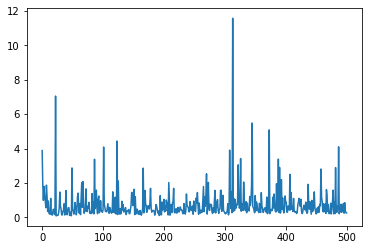

train_motion w teacher epoch 0 / step 505 ---- loss 0.380
train_motion w teacher epoch 0 / step 510 ---- loss 1.536
train_motion w teacher epoch 0 / step 515 ---- loss 0.808
train_motion w teacher epoch 0 / step 520 ---- loss 0.405
train_motion w teacher epoch 0 / step 525 ---- loss 0.957
train_motion w teacher epoch 0 / step 530 ---- loss 0.582
train_motion w teacher epoch 0 / step 535 ---- loss 0.680
train_motion w teacher epoch 0 / step 540 ---- loss 0.751
train_motion w teacher epoch 0 / step 545 ---- loss 0.915
train_motion w teacher epoch 0 / step 550 ---- loss 0.578
train_motion w teacher epoch 0 / step 555 ---- loss 0.846
train_motion w teacher epoch 0 / step 560 ---- loss 1.067
train_motion w teacher epoch 0 / step 565 ---- loss 0.586
train_motion w teacher epoch 0 / step 570 ---- loss 0.626
train_motion w teacher epoch 0 / step 575 ---- loss 0.593
train_motion w teacher epoch 0 / step 580 ---- loss 0.681
train_motion w teacher epoch 0 / step 585 ---- loss 1.054
train_motion w

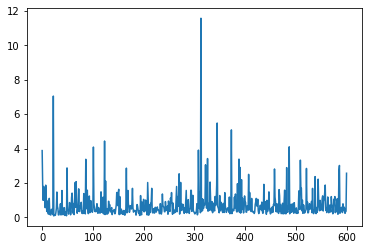

train_motion w teacher epoch 0 / step 605 ---- loss 0.762
train_motion w teacher epoch 0 / step 610 ---- loss 0.442
train_motion w teacher epoch 0 / step 615 ---- loss 0.564
train_motion w teacher epoch 0 / step 620 ---- loss 0.613
train_motion w teacher epoch 0 / step 625 ---- loss 0.597
train_motion w teacher epoch 0 / step 630 ---- loss 0.272
train_motion w teacher epoch 0 / step 635 ---- loss 0.418
train_motion w teacher epoch 0 / step 640 ---- loss 0.869
train_motion w teacher epoch 0 / step 645 ---- loss 0.979
train_motion w teacher epoch 0 / step 650 ---- loss 0.446
train_motion w teacher epoch 0 / step 655 ---- loss 1.155
train_motion w teacher epoch 0 / step 660 ---- loss 0.531
train_motion w teacher epoch 0 / step 665 ---- loss 0.625
train_motion w teacher epoch 0 / step 670 ---- loss 1.225
train_motion w teacher epoch 0 / step 675 ---- loss 0.468
train_motion w teacher epoch 0 / step 680 ---- loss 0.244
train_motion w teacher epoch 0 / step 685 ---- loss 0.418
train_motion w

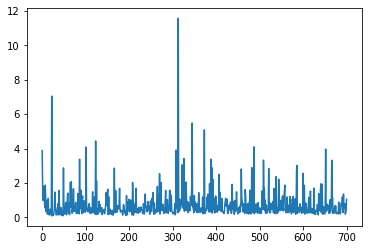

train_motion w teacher epoch 0 / step 705 ---- loss 0.285
train_motion w teacher epoch 0 / step 710 ---- loss 0.461
train_motion w teacher epoch 0 / step 715 ---- loss 0.615
train_motion w teacher epoch 0 / step 720 ---- loss 1.673
train_motion w teacher epoch 0 / step 725 ---- loss 0.682
train_motion w teacher epoch 0 / step 730 ---- loss 1.401
train_motion w teacher epoch 0 / step 735 ---- loss 0.449
train_motion w teacher epoch 0 / step 740 ---- loss 0.391
train_motion w teacher epoch 0 / step 745 ---- loss 0.606
train_motion w teacher epoch 0 / step 750 ---- loss 1.164
train_motion w teacher epoch 0 / step 755 ---- loss 0.651
train_motion w teacher epoch 0 / step 760 ---- loss 0.414
train_motion w teacher epoch 0 / step 765 ---- loss 0.463
train_motion w teacher epoch 0 / step 770 ---- loss 0.391
train_motion w teacher epoch 0 / step 775 ---- loss 0.322
train_motion w teacher epoch 0 / step 780 ---- loss 0.578
train_motion w teacher epoch 0 / step 785 ---- loss 1.326
train_motion w

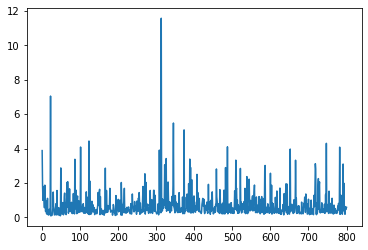

train_motion w teacher epoch 0 / step 805 ---- loss 0.512
train_motion w teacher epoch 0 / step 810 ---- loss 0.501
train_motion w teacher epoch 0 / step 815 ---- loss 1.292
train_motion w teacher epoch 0 / step 820 ---- loss 0.849
train_motion w teacher epoch 0 / step 825 ---- loss 0.613
train_motion w teacher epoch 0 / step 830 ---- loss 0.836
train_motion w teacher epoch 0 / step 835 ---- loss 0.420
train_motion w teacher epoch 0 / step 840 ---- loss 0.431
train_motion w teacher epoch 0 / step 845 ---- loss 0.735
train_motion w teacher epoch 0 / step 850 ---- loss 0.476
train_motion w teacher epoch 0 / step 855 ---- loss 0.790
train_motion w teacher epoch 0 / step 860 ---- loss 0.317
train_motion w teacher epoch 0 / step 865 ---- loss 0.387
train_motion w teacher epoch 0 / step 870 ---- loss 0.572
train_motion w teacher epoch 0 / step 875 ---- loss 0.529
train_motion w teacher epoch 0 / step 880 ---- loss 0.294
train_motion w teacher epoch 0 / step 885 ---- loss 1.239
train_motion w

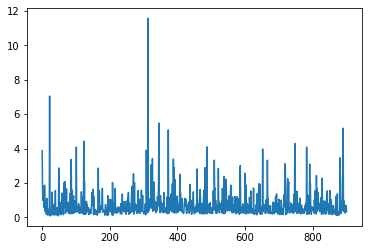

train_motion w teacher epoch 0 / step 905 ---- loss 0.534
train_motion w teacher epoch 0 / step 910 ---- loss 0.924
train_motion w teacher epoch 0 / step 915 ---- loss 0.827
train_motion w teacher epoch 0 / step 920 ---- loss 0.867
train_motion w teacher epoch 0 / step 925 ---- loss 0.749
train_motion w teacher epoch 0 / step 930 ---- loss 0.360
train_motion w teacher epoch 0 / step 935 ---- loss 0.575
train_motion w teacher epoch 0 / step 940 ---- loss 0.744
train_motion w teacher epoch 0 / step 945 ---- loss 2.127
train_motion w teacher epoch 0 / step 950 ---- loss 0.501
train_motion w teacher epoch 0 / step 955 ---- loss 1.082
train_motion w teacher epoch 0 / step 960 ---- loss 1.218
train_motion w teacher epoch 0 / step 965 ---- loss 0.630
train_motion w teacher epoch 0 / step 970 ---- loss 0.768
train_motion w teacher epoch 0 / step 975 ---- loss 1.253
train_motion w teacher epoch 0 / step 980 ---- loss 0.799
train_motion w teacher epoch 0 / step 985 ---- loss 1.099
train_motion w

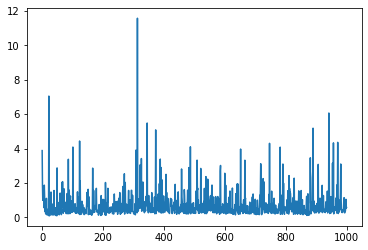

train_motion w teacher epoch 0 / step 1005 ---- loss 0.403
train_motion w teacher epoch 0 / step 1010 ---- loss 0.591
train_motion w teacher epoch 0 / step 1015 ---- loss 0.670
train_motion w teacher epoch 0 / step 1020 ---- loss 0.554
train_motion w teacher epoch 0 / step 1025 ---- loss 1.427
train_motion w teacher epoch 0 / step 1030 ---- loss 1.323
train_motion w teacher epoch 0 / step 1035 ---- loss 0.507
train_motion w teacher epoch 0 / step 1040 ---- loss 0.475
train_motion w teacher epoch 0 / step 1045 ---- loss 0.498
train_motion w teacher epoch 0 / step 1050 ---- loss 0.559
train_motion w teacher epoch 0 / step 1055 ---- loss 1.079
train_motion w teacher epoch 0 / step 1060 ---- loss 0.565
train_motion w teacher epoch 0 / step 1065 ---- loss 0.456
train_motion w teacher epoch 0 / step 1070 ---- loss 0.727
train_motion w teacher epoch 0 / step 1075 ---- loss 0.383
train_motion w teacher epoch 0 / step 1080 ---- loss 0.752
train_motion w teacher epoch 0 / step 1085 ---- loss 1.2

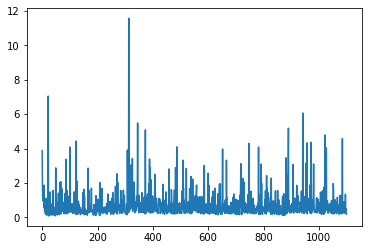

train_motion w teacher epoch 0 / step 1105 ---- loss 0.305
train_motion w teacher epoch 0 / step 1110 ---- loss 1.012
train_motion w teacher epoch 0 / step 1115 ---- loss 0.824
train_motion w teacher epoch 0 / step 1120 ---- loss 0.865
train_motion w teacher epoch 0 / step 1125 ---- loss 0.814
train_motion w teacher epoch 0 / step 1130 ---- loss 0.514
train_motion w teacher epoch 0 / step 1135 ---- loss 0.386
train_motion w teacher epoch 0 / step 1140 ---- loss 0.579
train_motion w teacher epoch 0 / step 1145 ---- loss 0.769
train_motion w teacher epoch 0 / step 1150 ---- loss 0.842
train_motion w teacher epoch 0 / step 1155 ---- loss 0.539
train_motion w teacher epoch 0 / step 1160 ---- loss 0.409
train_motion w teacher epoch 0 / step 1165 ---- loss 0.737
train_motion w teacher epoch 0 / step 1170 ---- loss 1.004
train_motion w teacher epoch 0 / step 1175 ---- loss 0.593
train_motion w teacher epoch 0 / step 1180 ---- loss 0.355
train_motion w teacher epoch 0 / step 1185 ---- loss 0.4

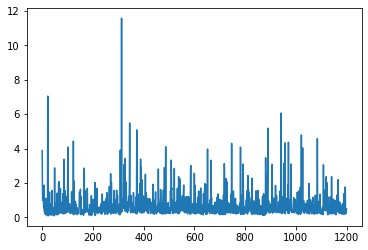

train_motion w teacher epoch 0 / step 1205 ---- loss 0.575
train_motion w teacher epoch 0 / step 1210 ---- loss 0.303
train_motion w teacher epoch 0 / step 1215 ---- loss 0.608
train_motion w teacher epoch 0 / step 1220 ---- loss 0.569
train_motion w teacher epoch 0 / step 1225 ---- loss 0.243
train_motion w teacher epoch 0 / step 1230 ---- loss 1.326
train_motion w teacher epoch 0 / step 1235 ---- loss 1.319
train_motion w teacher epoch 0 / step 1240 ---- loss 0.416
train_motion w teacher epoch 0 / step 1245 ---- loss 0.677
train_motion w teacher epoch 1 / step 0 ---- loss 0.690
train_motion w teacher epoch 1 / step 5 ---- loss 0.451
train_motion w teacher epoch 1 / step 10 ---- loss 0.937
train_motion w teacher epoch 1 / step 15 ---- loss 0.520
train_motion w teacher epoch 1 / step 20 ---- loss 0.666
train_motion w teacher epoch 1 / step 25 ---- loss 0.719
train_motion w teacher epoch 1 / step 30 ---- loss 0.663
train_motion w teacher epoch 1 / step 35 ---- loss 0.424
train_motion w 

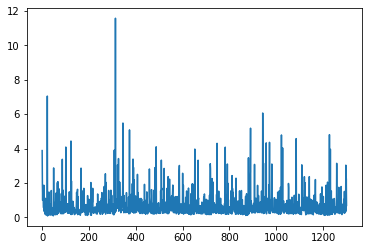

train_motion w teacher epoch 1 / step 55 ---- loss 1.802
train_motion w teacher epoch 1 / step 60 ---- loss 1.036
train_motion w teacher epoch 1 / step 65 ---- loss 0.444
train_motion w teacher epoch 1 / step 70 ---- loss 0.904
train_motion w teacher epoch 1 / step 75 ---- loss 0.457
train_motion w teacher epoch 1 / step 80 ---- loss 0.434
train_motion w teacher epoch 1 / step 85 ---- loss 0.616
train_motion w teacher epoch 1 / step 90 ---- loss 0.459
train_motion w teacher epoch 1 / step 95 ---- loss 0.474
train_motion w teacher epoch 1 / step 100 ---- loss 0.904
train_motion w teacher epoch 1 / step 105 ---- loss 0.482
train_motion w teacher epoch 1 / step 110 ---- loss 1.301
train_motion w teacher epoch 1 / step 115 ---- loss 0.683
train_motion w teacher epoch 1 / step 120 ---- loss 0.400
train_motion w teacher epoch 1 / step 125 ---- loss 0.389
train_motion w teacher epoch 1 / step 130 ---- loss 0.451
train_motion w teacher epoch 1 / step 135 ---- loss 0.797
train_motion w teacher 

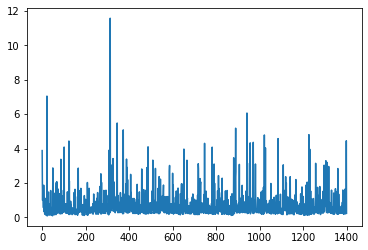

train_motion w teacher epoch 1 / step 155 ---- loss 0.987
train_motion w teacher epoch 1 / step 160 ---- loss 0.285
train_motion w teacher epoch 1 / step 165 ---- loss 0.530
train_motion w teacher epoch 1 / step 170 ---- loss 0.495
train_motion w teacher epoch 1 / step 175 ---- loss 0.666
train_motion w teacher epoch 1 / step 180 ---- loss 0.681
train_motion w teacher epoch 1 / step 185 ---- loss 0.516
train_motion w teacher epoch 1 / step 190 ---- loss 0.553
train_motion w teacher epoch 1 / step 195 ---- loss 0.284
train_motion w teacher epoch 1 / step 200 ---- loss 0.602
train_motion w teacher epoch 1 / step 205 ---- loss 1.300
train_motion w teacher epoch 1 / step 210 ---- loss 0.581
train_motion w teacher epoch 1 / step 215 ---- loss 0.525
train_motion w teacher epoch 1 / step 220 ---- loss 0.771
train_motion w teacher epoch 1 / step 225 ---- loss 0.408
train_motion w teacher epoch 1 / step 230 ---- loss 0.410
train_motion w teacher epoch 1 / step 235 ---- loss 0.485
train_motion w

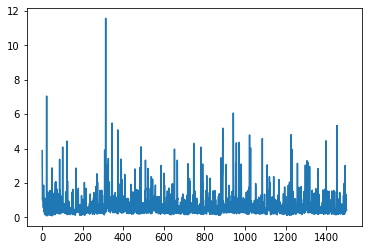

train_motion w teacher epoch 1 / step 255 ---- loss 0.606
train_motion w teacher epoch 1 / step 260 ---- loss 0.805
train_motion w teacher epoch 1 / step 265 ---- loss 0.827
train_motion w teacher epoch 1 / step 270 ---- loss 0.509
train_motion w teacher epoch 1 / step 275 ---- loss 0.568
train_motion w teacher epoch 1 / step 280 ---- loss 0.938
train_motion w teacher epoch 1 / step 285 ---- loss 0.455
train_motion w teacher epoch 1 / step 290 ---- loss 0.436
train_motion w teacher epoch 1 / step 295 ---- loss 0.333
train_motion w teacher epoch 1 / step 300 ---- loss 0.756
train_motion w teacher epoch 1 / step 305 ---- loss 0.897
train_motion w teacher epoch 1 / step 310 ---- loss 0.351
train_motion w teacher epoch 1 / step 315 ---- loss 0.540
train_motion w teacher epoch 1 / step 320 ---- loss 1.166
train_motion w teacher epoch 1 / step 325 ---- loss 0.715
train_motion w teacher epoch 1 / step 330 ---- loss 0.653
train_motion w teacher epoch 1 / step 335 ---- loss 0.413
train_motion w

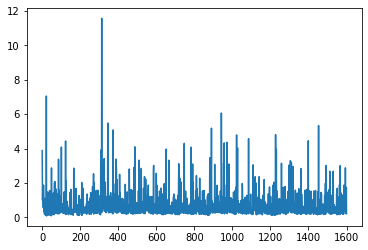

train_motion w teacher epoch 1 / step 355 ---- loss 0.436
train_motion w teacher epoch 1 / step 360 ---- loss 0.493
train_motion w teacher epoch 1 / step 365 ---- loss 0.767
train_motion w teacher epoch 1 / step 370 ---- loss 0.576
train_motion w teacher epoch 1 / step 375 ---- loss 1.220
train_motion w teacher epoch 1 / step 380 ---- loss 0.293
train_motion w teacher epoch 1 / step 385 ---- loss 0.719
train_motion w teacher epoch 1 / step 390 ---- loss 0.294
train_motion w teacher epoch 1 / step 395 ---- loss 0.605
train_motion w teacher epoch 1 / step 400 ---- loss 0.596
train_motion w teacher epoch 1 / step 405 ---- loss 1.035
train_motion w teacher epoch 1 / step 410 ---- loss 1.014
train_motion w teacher epoch 1 / step 415 ---- loss 0.615
train_motion w teacher epoch 1 / step 420 ---- loss 0.513
train_motion w teacher epoch 1 / step 425 ---- loss 0.604
train_motion w teacher epoch 1 / step 430 ---- loss 1.127
train_motion w teacher epoch 1 / step 435 ---- loss 0.421
train_motion w

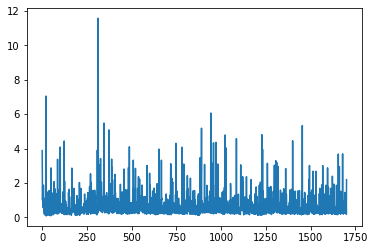

train_motion w teacher epoch 1 / step 455 ---- loss 0.747
train_motion w teacher epoch 1 / step 460 ---- loss 0.832
train_motion w teacher epoch 1 / step 465 ---- loss 0.678
train_motion w teacher epoch 1 / step 470 ---- loss 0.822
train_motion w teacher epoch 1 / step 475 ---- loss 0.690
train_motion w teacher epoch 1 / step 480 ---- loss 0.721
train_motion w teacher epoch 1 / step 485 ---- loss 0.866
train_motion w teacher epoch 1 / step 490 ---- loss 1.211
train_motion w teacher epoch 1 / step 495 ---- loss 0.692
train_motion w teacher epoch 1 / step 500 ---- loss 0.438
train_motion w teacher epoch 1 / step 505 ---- loss 1.123
train_motion w teacher epoch 1 / step 510 ---- loss 1.506
train_motion w teacher epoch 1 / step 515 ---- loss 0.752
train_motion w teacher epoch 1 / step 520 ---- loss 0.712
train_motion w teacher epoch 1 / step 525 ---- loss 0.459
train_motion w teacher epoch 1 / step 530 ---- loss 0.378
train_motion w teacher epoch 1 / step 535 ---- loss 0.608
train_motion w

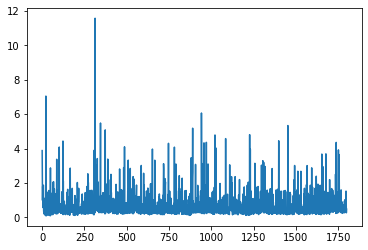

train_motion w teacher epoch 1 / step 555 ---- loss 0.316
train_motion w teacher epoch 1 / step 560 ---- loss 0.872
train_motion w teacher epoch 1 / step 565 ---- loss 0.573
train_motion w teacher epoch 1 / step 570 ---- loss 0.640
train_motion w teacher epoch 1 / step 575 ---- loss 0.593
train_motion w teacher epoch 1 / step 580 ---- loss 0.841
train_motion w teacher epoch 1 / step 585 ---- loss 0.461
train_motion w teacher epoch 1 / step 590 ---- loss 0.531
train_motion w teacher epoch 1 / step 595 ---- loss 0.862
train_motion w teacher epoch 1 / step 600 ---- loss 0.489
train_motion w teacher epoch 1 / step 605 ---- loss 0.697
train_motion w teacher epoch 1 / step 610 ---- loss 0.361
train_motion w teacher epoch 1 / step 615 ---- loss 0.570
train_motion w teacher epoch 1 / step 620 ---- loss 0.346
train_motion w teacher epoch 1 / step 625 ---- loss 0.603
train_motion w teacher epoch 1 / step 630 ---- loss 0.564
train_motion w teacher epoch 1 / step 635 ---- loss 0.506
train_motion w

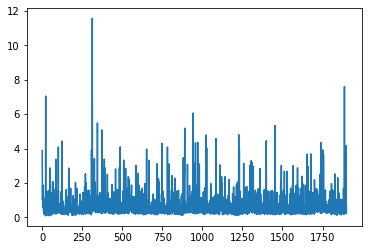

train_motion w teacher epoch 1 / step 655 ---- loss 0.404
train_motion w teacher epoch 1 / step 660 ---- loss 0.901
train_motion w teacher epoch 1 / step 665 ---- loss 0.406
train_motion w teacher epoch 1 / step 670 ---- loss 0.422
train_motion w teacher epoch 1 / step 675 ---- loss 1.363
train_motion w teacher epoch 1 / step 680 ---- loss 0.605
train_motion w teacher epoch 1 / step 685 ---- loss 0.539
train_motion w teacher epoch 1 / step 690 ---- loss 0.632
train_motion w teacher epoch 1 / step 695 ---- loss 0.919
train_motion w teacher epoch 1 / step 700 ---- loss 0.614
train_motion w teacher epoch 1 / step 705 ---- loss 0.544
train_motion w teacher epoch 1 / step 710 ---- loss 0.555
train_motion w teacher epoch 1 / step 715 ---- loss 0.597
train_motion w teacher epoch 1 / step 720 ---- loss 0.576
train_motion w teacher epoch 1 / step 725 ---- loss 0.547
train_motion w teacher epoch 1 / step 730 ---- loss 0.306
train_motion w teacher epoch 1 / step 735 ---- loss 0.467
train_motion w

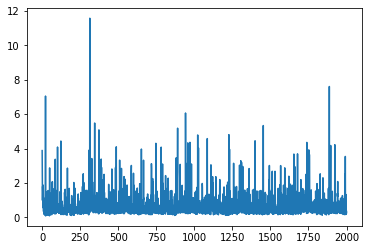

train_motion w teacher epoch 1 / step 755 ---- loss 0.469
train_motion w teacher epoch 1 / step 760 ---- loss 0.592
train_motion w teacher epoch 1 / step 765 ---- loss 0.566
train_motion w teacher epoch 1 / step 770 ---- loss 0.447
train_motion w teacher epoch 1 / step 775 ---- loss 0.430
train_motion w teacher epoch 1 / step 780 ---- loss 0.495
train_motion w teacher epoch 1 / step 785 ---- loss 0.547
train_motion w teacher epoch 1 / step 790 ---- loss 0.642
train_motion w teacher epoch 1 / step 795 ---- loss 0.482
train_motion w teacher epoch 1 / step 800 ---- loss 0.732
train_motion w teacher epoch 1 / step 805 ---- loss 0.427
train_motion w teacher epoch 1 / step 810 ---- loss 0.475
train_motion w teacher epoch 1 / step 815 ---- loss 0.315
train_motion w teacher epoch 1 / step 820 ---- loss 0.276
train_motion w teacher epoch 1 / step 825 ---- loss 0.461
train_motion w teacher epoch 1 / step 830 ---- loss 0.570
train_motion w teacher epoch 1 / step 835 ---- loss 0.733
train_motion w

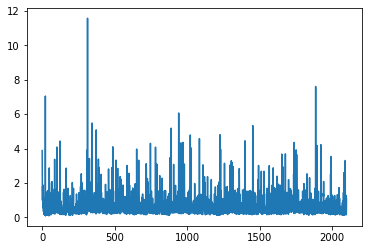

train_motion w teacher epoch 1 / step 855 ---- loss 0.457
train_motion w teacher epoch 1 / step 860 ---- loss 0.695
train_motion w teacher epoch 1 / step 865 ---- loss 0.441
train_motion w teacher epoch 1 / step 870 ---- loss 0.609
train_motion w teacher epoch 1 / step 875 ---- loss 0.376
train_motion w teacher epoch 1 / step 880 ---- loss 0.536
train_motion w teacher epoch 1 / step 885 ---- loss 0.333
train_motion w teacher epoch 1 / step 890 ---- loss 0.770
train_motion w teacher epoch 1 / step 895 ---- loss 0.506
train_motion w teacher epoch 1 / step 900 ---- loss 0.440
train_motion w teacher epoch 1 / step 905 ---- loss 0.871
train_motion w teacher epoch 1 / step 910 ---- loss 0.665
train_motion w teacher epoch 1 / step 915 ---- loss 0.309
train_motion w teacher epoch 1 / step 920 ---- loss 2.361
train_motion w teacher epoch 1 / step 925 ---- loss 0.765
train_motion w teacher epoch 1 / step 930 ---- loss 1.208
train_motion w teacher epoch 1 / step 935 ---- loss 1.272
train_motion w

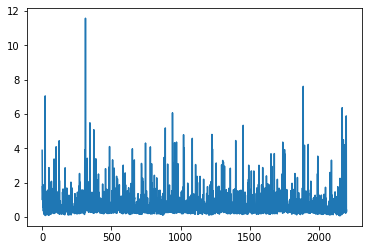

train_motion w teacher epoch 1 / step 955 ---- loss 0.838
train_motion w teacher epoch 1 / step 960 ---- loss 0.454
train_motion w teacher epoch 1 / step 965 ---- loss 0.616
train_motion w teacher epoch 1 / step 970 ---- loss 0.575
train_motion w teacher epoch 1 / step 975 ---- loss 2.405
train_motion w teacher epoch 1 / step 980 ---- loss 1.133
train_motion w teacher epoch 1 / step 985 ---- loss 1.288
train_motion w teacher epoch 1 / step 990 ---- loss 1.347
train_motion w teacher epoch 1 / step 995 ---- loss 0.649
train_motion w teacher epoch 1 / step 1000 ---- loss 0.469
train_motion w teacher epoch 1 / step 1005 ---- loss 0.683
train_motion w teacher epoch 1 / step 1010 ---- loss 0.485
train_motion w teacher epoch 1 / step 1015 ---- loss 0.938
train_motion w teacher epoch 1 / step 1020 ---- loss 0.742
train_motion w teacher epoch 1 / step 1025 ---- loss 0.751
train_motion w teacher epoch 1 / step 1030 ---- loss 1.417
train_motion w teacher epoch 1 / step 1035 ---- loss 0.932
train_

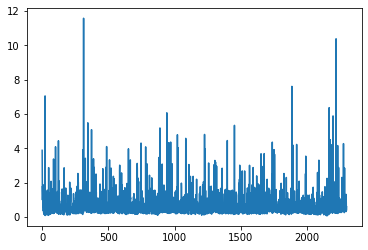

train_motion w teacher epoch 1 / step 1055 ---- loss 0.347
train_motion w teacher epoch 1 / step 1060 ---- loss 0.543
train_motion w teacher epoch 1 / step 1065 ---- loss 0.427
train_motion w teacher epoch 1 / step 1070 ---- loss 0.876
train_motion w teacher epoch 1 / step 1075 ---- loss 1.430
train_motion w teacher epoch 1 / step 1080 ---- loss 0.818
train_motion w teacher epoch 1 / step 1085 ---- loss 0.704
train_motion w teacher epoch 1 / step 1090 ---- loss 1.230
train_motion w teacher epoch 1 / step 1095 ---- loss 0.327
train_motion w teacher epoch 1 / step 1100 ---- loss 0.664
train_motion w teacher epoch 1 / step 1105 ---- loss 0.802
train_motion w teacher epoch 1 / step 1110 ---- loss 0.474
train_motion w teacher epoch 1 / step 1115 ---- loss 0.536
train_motion w teacher epoch 1 / step 1120 ---- loss 0.365
train_motion w teacher epoch 1 / step 1125 ---- loss 0.404
train_motion w teacher epoch 1 / step 1130 ---- loss 0.617
train_motion w teacher epoch 1 / step 1135 ---- loss 0.3

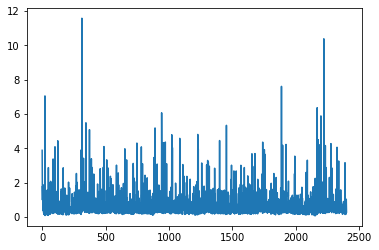

train_motion w teacher epoch 1 / step 1155 ---- loss 0.677
train_motion w teacher epoch 1 / step 1160 ---- loss 0.433
train_motion w teacher epoch 1 / step 1165 ---- loss 1.245
train_motion w teacher epoch 1 / step 1170 ---- loss 0.329
train_motion w teacher epoch 1 / step 1175 ---- loss 0.460
train_motion w teacher epoch 1 / step 1180 ---- loss 0.377
train_motion w teacher epoch 1 / step 1185 ---- loss 0.399
train_motion w teacher epoch 1 / step 1190 ---- loss 1.233
train_motion w teacher epoch 1 / step 1195 ---- loss 0.480
train_motion w teacher epoch 1 / step 1200 ---- loss 0.213
train_motion w teacher epoch 1 / step 1205 ---- loss 0.649
train_motion w teacher epoch 1 / step 1210 ---- loss 0.747
train_motion w teacher epoch 1 / step 1215 ---- loss 1.302
train_motion w teacher epoch 1 / step 1220 ---- loss 0.835
train_motion w teacher epoch 1 / step 1225 ---- loss 0.489
train_motion w teacher epoch 1 / step 1230 ---- loss 0.932
train_motion w teacher epoch 1 / step 1235 ---- loss 0.5

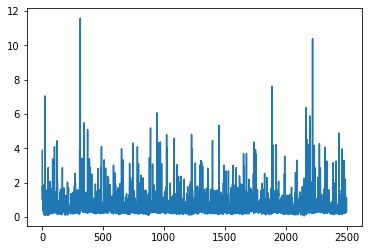

train_motion w teacher epoch 2 / step 5 ---- loss 0.506
train_motion w teacher epoch 2 / step 10 ---- loss 0.474
train_motion w teacher epoch 2 / step 15 ---- loss 0.691
train_motion w teacher epoch 2 / step 20 ---- loss 0.602
train_motion w teacher epoch 2 / step 25 ---- loss 0.715
train_motion w teacher epoch 2 / step 30 ---- loss 0.586
train_motion w teacher epoch 2 / step 35 ---- loss 1.034
train_motion w teacher epoch 2 / step 40 ---- loss 0.470
train_motion w teacher epoch 2 / step 45 ---- loss 0.761
train_motion w teacher epoch 2 / step 50 ---- loss 0.344
train_motion w teacher epoch 2 / step 55 ---- loss 0.425
train_motion w teacher epoch 2 / step 60 ---- loss 0.726
train_motion w teacher epoch 2 / step 65 ---- loss 0.328
train_motion w teacher epoch 2 / step 70 ---- loss 0.410
train_motion w teacher epoch 2 / step 75 ---- loss 1.095
train_motion w teacher epoch 2 / step 80 ---- loss 1.315
train_motion w teacher epoch 2 / step 85 ---- loss 0.724
train_motion w teacher epoch 2 /

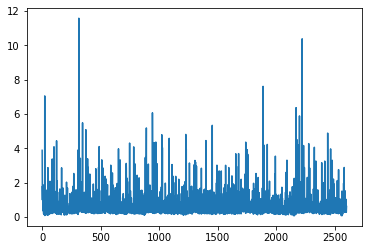

train_motion w teacher epoch 2 / step 105 ---- loss 0.730
train_motion w teacher epoch 2 / step 110 ---- loss 0.593
train_motion w teacher epoch 2 / step 115 ---- loss 0.801
train_motion w teacher epoch 2 / step 120 ---- loss 0.709
train_motion w teacher epoch 2 / step 125 ---- loss 0.551
train_motion w teacher epoch 2 / step 130 ---- loss 0.337
train_motion w teacher epoch 2 / step 135 ---- loss 2.277
train_motion w teacher epoch 2 / step 140 ---- loss 0.664
train_motion w teacher epoch 2 / step 145 ---- loss 0.921
train_motion w teacher epoch 2 / step 150 ---- loss 0.471
train_motion w teacher epoch 2 / step 155 ---- loss 0.613
train_motion w teacher epoch 2 / step 160 ---- loss 0.316
train_motion w teacher epoch 2 / step 165 ---- loss 0.566
train_motion w teacher epoch 2 / step 170 ---- loss 0.593
train_motion w teacher epoch 2 / step 175 ---- loss 0.994
train_motion w teacher epoch 2 / step 180 ---- loss 0.721
train_motion w teacher epoch 2 / step 185 ---- loss 0.556
train_motion w

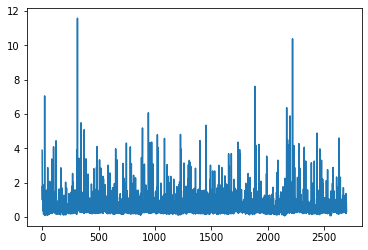

train_motion w teacher epoch 2 / step 205 ---- loss 0.265
train_motion w teacher epoch 2 / step 210 ---- loss 0.257
train_motion w teacher epoch 2 / step 215 ---- loss 1.185
train_motion w teacher epoch 2 / step 220 ---- loss 0.548
train_motion w teacher epoch 2 / step 225 ---- loss 0.655
train_motion w teacher epoch 2 / step 230 ---- loss 0.921
train_motion w teacher epoch 2 / step 235 ---- loss 0.713
train_motion w teacher epoch 2 / step 240 ---- loss 0.410
train_motion w teacher epoch 2 / step 245 ---- loss 0.409
train_motion w teacher epoch 2 / step 250 ---- loss 0.741
train_motion w teacher epoch 2 / step 255 ---- loss 0.272
train_motion w teacher epoch 2 / step 260 ---- loss 0.205
train_motion w teacher epoch 2 / step 265 ---- loss 0.586
train_motion w teacher epoch 2 / step 270 ---- loss 0.323
train_motion w teacher epoch 2 / step 275 ---- loss 0.568
train_motion w teacher epoch 2 / step 280 ---- loss 0.216
train_motion w teacher epoch 2 / step 285 ---- loss 0.756
train_motion w

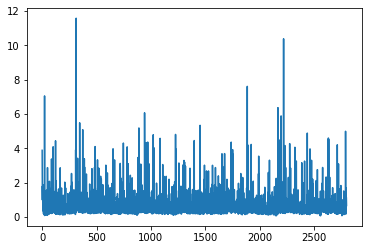

train_motion w teacher epoch 2 / step 305 ---- loss 0.409
train_motion w teacher epoch 2 / step 310 ---- loss 0.747
train_motion w teacher epoch 2 / step 315 ---- loss 0.750
train_motion w teacher epoch 2 / step 320 ---- loss 0.460
train_motion w teacher epoch 2 / step 325 ---- loss 0.539
train_motion w teacher epoch 2 / step 330 ---- loss 0.885
train_motion w teacher epoch 2 / step 335 ---- loss 1.808
train_motion w teacher epoch 2 / step 340 ---- loss 0.365
train_motion w teacher epoch 2 / step 345 ---- loss 0.348
train_motion w teacher epoch 2 / step 350 ---- loss 0.498
train_motion w teacher epoch 2 / step 355 ---- loss 0.504
train_motion w teacher epoch 2 / step 360 ---- loss 0.361
train_motion w teacher epoch 2 / step 365 ---- loss 0.363
train_motion w teacher epoch 2 / step 370 ---- loss 1.503
train_motion w teacher epoch 2 / step 375 ---- loss 0.517
train_motion w teacher epoch 2 / step 380 ---- loss 0.758
train_motion w teacher epoch 2 / step 385 ---- loss 0.629
train_motion w

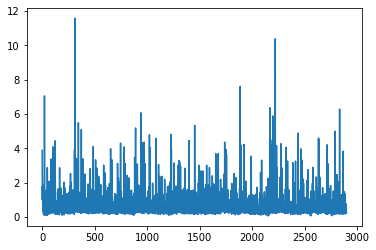

train_motion w teacher epoch 2 / step 405 ---- loss 0.650
train_motion w teacher epoch 2 / step 410 ---- loss 0.520
train_motion w teacher epoch 2 / step 415 ---- loss 0.296
train_motion w teacher epoch 2 / step 420 ---- loss 0.987
train_motion w teacher epoch 2 / step 425 ---- loss 1.112
train_motion w teacher epoch 2 / step 430 ---- loss 0.687
train_motion w teacher epoch 2 / step 435 ---- loss 0.285
train_motion w teacher epoch 2 / step 440 ---- loss 0.682
train_motion w teacher epoch 2 / step 445 ---- loss 0.432
train_motion w teacher epoch 2 / step 450 ---- loss 0.744
train_motion w teacher epoch 2 / step 455 ---- loss 0.949
train_motion w teacher epoch 2 / step 460 ---- loss 0.401
train_motion w teacher epoch 2 / step 465 ---- loss 0.551
train_motion w teacher epoch 2 / step 470 ---- loss 0.238
train_motion w teacher epoch 2 / step 475 ---- loss 0.502
train_motion w teacher epoch 2 / step 480 ---- loss 0.380
train_motion w teacher epoch 2 / step 485 ---- loss 0.401
train_motion w

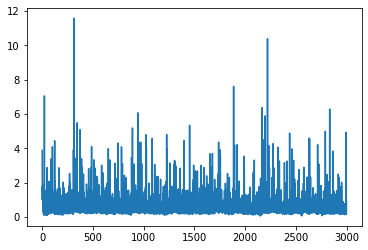

train_motion w teacher epoch 2 / step 505 ---- loss 0.462
train_motion w teacher epoch 2 / step 510 ---- loss 1.513
train_motion w teacher epoch 2 / step 515 ---- loss 0.451
train_motion w teacher epoch 2 / step 520 ---- loss 1.899
train_motion w teacher epoch 2 / step 525 ---- loss 0.677
train_motion w teacher epoch 2 / step 530 ---- loss 0.682
train_motion w teacher epoch 2 / step 535 ---- loss 1.401
train_motion w teacher epoch 2 / step 540 ---- loss 0.736
train_motion w teacher epoch 2 / step 545 ---- loss 0.439
train_motion w teacher epoch 2 / step 550 ---- loss 0.798
train_motion w teacher epoch 2 / step 555 ---- loss 0.413
train_motion w teacher epoch 2 / step 560 ---- loss 0.301
train_motion w teacher epoch 2 / step 565 ---- loss 0.302
train_motion w teacher epoch 2 / step 570 ---- loss 0.483
train_motion w teacher epoch 2 / step 575 ---- loss 0.449
train_motion w teacher epoch 2 / step 580 ---- loss 0.673
train_motion w teacher epoch 2 / step 585 ---- loss 0.910
train_motion w

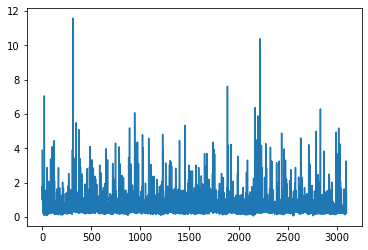

train_motion w teacher epoch 2 / step 605 ---- loss 0.555
train_motion w teacher epoch 2 / step 610 ---- loss 0.565
train_motion w teacher epoch 2 / step 615 ---- loss 0.545
train_motion w teacher epoch 2 / step 620 ---- loss 0.689
train_motion w teacher epoch 2 / step 625 ---- loss 1.857
train_motion w teacher epoch 2 / step 630 ---- loss 0.926
train_motion w teacher epoch 2 / step 635 ---- loss 1.192
train_motion w teacher epoch 2 / step 640 ---- loss 1.513
train_motion w teacher epoch 2 / step 645 ---- loss 0.580
train_motion w teacher epoch 2 / step 650 ---- loss 0.757
train_motion w teacher epoch 2 / step 655 ---- loss 0.583
train_motion w teacher epoch 2 / step 660 ---- loss 0.598
train_motion w teacher epoch 2 / step 665 ---- loss 0.460
train_motion w teacher epoch 2 / step 670 ---- loss 0.532
train_motion w teacher epoch 2 / step 675 ---- loss 0.497
train_motion w teacher epoch 2 / step 680 ---- loss 0.256
train_motion w teacher epoch 2 / step 685 ---- loss 0.388
train_motion w

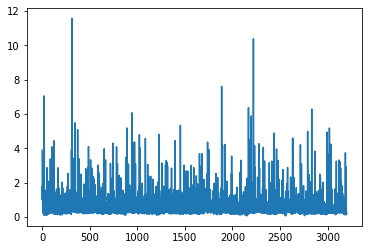

train_motion w teacher epoch 2 / step 705 ---- loss 0.724
train_motion w teacher epoch 2 / step 710 ---- loss 0.792
train_motion w teacher epoch 2 / step 715 ---- loss 0.908
train_motion w teacher epoch 2 / step 720 ---- loss 0.975
train_motion w teacher epoch 2 / step 725 ---- loss 0.474
train_motion w teacher epoch 2 / step 730 ---- loss 0.330
train_motion w teacher epoch 2 / step 735 ---- loss 0.399
train_motion w teacher epoch 2 / step 740 ---- loss 0.870
train_motion w teacher epoch 2 / step 745 ---- loss 0.959
train_motion w teacher epoch 2 / step 750 ---- loss 0.435
train_motion w teacher epoch 2 / step 755 ---- loss 0.653
train_motion w teacher epoch 2 / step 760 ---- loss 0.347
train_motion w teacher epoch 2 / step 765 ---- loss 0.596
train_motion w teacher epoch 2 / step 770 ---- loss 0.482
train_motion w teacher epoch 2 / step 775 ---- loss 0.738
train_motion w teacher epoch 2 / step 780 ---- loss 0.352
train_motion w teacher epoch 2 / step 785 ---- loss 0.741
train_motion w

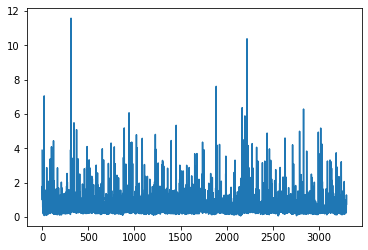

train_motion w teacher epoch 2 / step 805 ---- loss 0.210
train_motion w teacher epoch 2 / step 810 ---- loss 1.008
train_motion w teacher epoch 2 / step 815 ---- loss 0.709
train_motion w teacher epoch 2 / step 820 ---- loss 0.822
train_motion w teacher epoch 2 / step 825 ---- loss 1.674
train_motion w teacher epoch 2 / step 830 ---- loss 0.703
train_motion w teacher epoch 2 / step 835 ---- loss 1.197
train_motion w teacher epoch 2 / step 840 ---- loss 0.900
train_motion w teacher epoch 2 / step 845 ---- loss 0.404
train_motion w teacher epoch 2 / step 850 ---- loss 0.905
train_motion w teacher epoch 2 / step 855 ---- loss 1.394
train_motion w teacher epoch 2 / step 860 ---- loss 0.380
train_motion w teacher epoch 2 / step 865 ---- loss 0.503
train_motion w teacher epoch 2 / step 870 ---- loss 0.497
train_motion w teacher epoch 2 / step 875 ---- loss 0.619
train_motion w teacher epoch 2 / step 880 ---- loss 0.666
train_motion w teacher epoch 2 / step 885 ---- loss 0.572
train_motion w

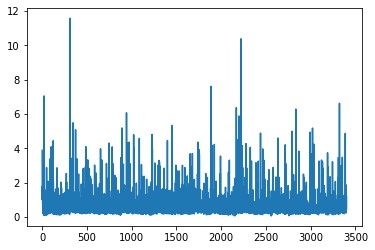

train_motion w teacher epoch 2 / step 905 ---- loss 1.411
train_motion w teacher epoch 2 / step 910 ---- loss 0.538
train_motion w teacher epoch 2 / step 915 ---- loss 0.645
train_motion w teacher epoch 2 / step 920 ---- loss 0.524
train_motion w teacher epoch 2 / step 925 ---- loss 0.531
train_motion w teacher epoch 2 / step 930 ---- loss 0.564
train_motion w teacher epoch 2 / step 935 ---- loss 0.402
train_motion w teacher epoch 2 / step 940 ---- loss 0.688
train_motion w teacher epoch 2 / step 945 ---- loss 0.344
train_motion w teacher epoch 2 / step 950 ---- loss 0.609
train_motion w teacher epoch 2 / step 955 ---- loss 0.895
train_motion w teacher epoch 2 / step 960 ---- loss 0.786
train_motion w teacher epoch 2 / step 965 ---- loss 1.149
train_motion w teacher epoch 2 / step 970 ---- loss 0.452
train_motion w teacher epoch 2 / step 975 ---- loss 0.404
train_motion w teacher epoch 2 / step 980 ---- loss 0.669
train_motion w teacher epoch 2 / step 985 ---- loss 0.584
train_motion w

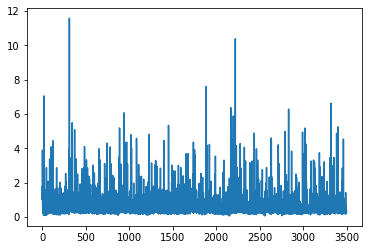

train_motion w teacher epoch 2 / step 1005 ---- loss 0.690
train_motion w teacher epoch 2 / step 1010 ---- loss 1.356
train_motion w teacher epoch 2 / step 1015 ---- loss 0.423
train_motion w teacher epoch 2 / step 1020 ---- loss 0.753
train_motion w teacher epoch 2 / step 1025 ---- loss 0.274
train_motion w teacher epoch 2 / step 1030 ---- loss 0.531
train_motion w teacher epoch 2 / step 1035 ---- loss 0.367
train_motion w teacher epoch 2 / step 1040 ---- loss 0.633
train_motion w teacher epoch 2 / step 1045 ---- loss 0.374
train_motion w teacher epoch 2 / step 1050 ---- loss 0.356
train_motion w teacher epoch 2 / step 1055 ---- loss 1.253
train_motion w teacher epoch 2 / step 1060 ---- loss 1.157
train_motion w teacher epoch 2 / step 1065 ---- loss 0.716
train_motion w teacher epoch 2 / step 1070 ---- loss 0.704
train_motion w teacher epoch 2 / step 1075 ---- loss 0.363
train_motion w teacher epoch 2 / step 1080 ---- loss 0.472
train_motion w teacher epoch 2 / step 1085 ---- loss 0.7

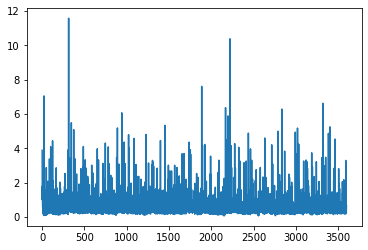

train_motion w teacher epoch 2 / step 1105 ---- loss 0.473
train_motion w teacher epoch 2 / step 1110 ---- loss 2.866
train_motion w teacher epoch 2 / step 1115 ---- loss 0.340
train_motion w teacher epoch 2 / step 1120 ---- loss 0.813
train_motion w teacher epoch 2 / step 1125 ---- loss 0.929
train_motion w teacher epoch 2 / step 1130 ---- loss 0.743
train_motion w teacher epoch 2 / step 1135 ---- loss 0.460
train_motion w teacher epoch 2 / step 1140 ---- loss 0.553
train_motion w teacher epoch 2 / step 1145 ---- loss 0.804
train_motion w teacher epoch 2 / step 1150 ---- loss 0.422
train_motion w teacher epoch 2 / step 1155 ---- loss 0.704
train_motion w teacher epoch 2 / step 1160 ---- loss 0.505
train_motion w teacher epoch 2 / step 1165 ---- loss 1.531
train_motion w teacher epoch 2 / step 1170 ---- loss 0.633
train_motion w teacher epoch 2 / step 1175 ---- loss 0.495
train_motion w teacher epoch 2 / step 1180 ---- loss 0.956
train_motion w teacher epoch 2 / step 1185 ---- loss 0.4

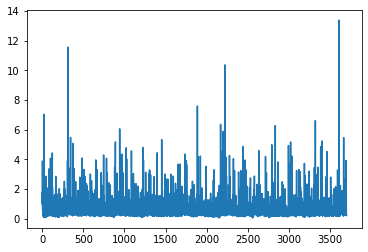

train_motion w teacher epoch 2 / step 1205 ---- loss 0.549
train_motion w teacher epoch 2 / step 1210 ---- loss 0.393
train_motion w teacher epoch 2 / step 1215 ---- loss 0.744
train_motion w teacher epoch 2 / step 1220 ---- loss 1.087
train_motion w teacher epoch 2 / step 1225 ---- loss 1.670
train_motion w teacher epoch 2 / step 1230 ---- loss 0.853
train_motion w teacher epoch 2 / step 1235 ---- loss 0.640
train_motion w teacher epoch 2 / step 1240 ---- loss 1.386
train_motion w teacher epoch 2 / step 1245 ---- loss 0.575
train_motion w teacher epoch 3 / step 0 ---- loss 0.562
train_motion w teacher epoch 3 / step 5 ---- loss 0.630
train_motion w teacher epoch 3 / step 10 ---- loss 0.442
train_motion w teacher epoch 3 / step 15 ---- loss 0.771
train_motion w teacher epoch 3 / step 20 ---- loss 0.321
train_motion w teacher epoch 3 / step 25 ---- loss 1.051
train_motion w teacher epoch 3 / step 30 ---- loss 0.750
train_motion w teacher epoch 3 / step 35 ---- loss 0.404
train_motion w 

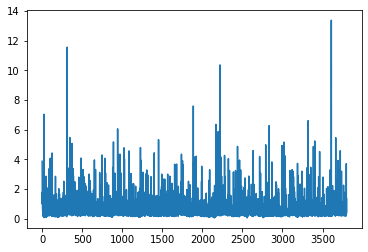

train_motion w teacher epoch 3 / step 55 ---- loss 0.709
train_motion w teacher epoch 3 / step 60 ---- loss 0.411
train_motion w teacher epoch 3 / step 65 ---- loss 1.793
train_motion w teacher epoch 3 / step 70 ---- loss 0.498
train_motion w teacher epoch 3 / step 75 ---- loss 0.520
train_motion w teacher epoch 3 / step 80 ---- loss 0.410
train_motion w teacher epoch 3 / step 85 ---- loss 0.768
train_motion w teacher epoch 3 / step 90 ---- loss 1.043
train_motion w teacher epoch 3 / step 95 ---- loss 0.656
train_motion w teacher epoch 3 / step 100 ---- loss 0.333
train_motion w teacher epoch 3 / step 105 ---- loss 1.326
train_motion w teacher epoch 3 / step 110 ---- loss 0.687
train_motion w teacher epoch 3 / step 115 ---- loss 0.563
train_motion w teacher epoch 3 / step 120 ---- loss 0.972
train_motion w teacher epoch 3 / step 125 ---- loss 0.430
train_motion w teacher epoch 3 / step 130 ---- loss 0.769
train_motion w teacher epoch 3 / step 135 ---- loss 0.512
train_motion w teacher 

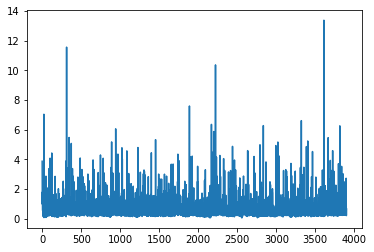

train_motion w teacher epoch 3 / step 155 ---- loss 1.045
train_motion w teacher epoch 3 / step 160 ---- loss 0.752
train_motion w teacher epoch 3 / step 165 ---- loss 0.561
train_motion w teacher epoch 3 / step 170 ---- loss 0.498
train_motion w teacher epoch 3 / step 175 ---- loss 0.441
train_motion w teacher epoch 3 / step 180 ---- loss 0.662
train_motion w teacher epoch 3 / step 185 ---- loss 0.415
train_motion w teacher epoch 3 / step 190 ---- loss 0.264
train_motion w teacher epoch 3 / step 195 ---- loss 0.315
train_motion w teacher epoch 3 / step 200 ---- loss 0.389
train_motion w teacher epoch 3 / step 205 ---- loss 1.706
train_motion w teacher epoch 3 / step 210 ---- loss 0.611
train_motion w teacher epoch 3 / step 215 ---- loss 0.935
train_motion w teacher epoch 3 / step 220 ---- loss 0.407
train_motion w teacher epoch 3 / step 225 ---- loss 1.301
train_motion w teacher epoch 3 / step 230 ---- loss 0.857
train_motion w teacher epoch 3 / step 235 ---- loss 0.603
train_motion w

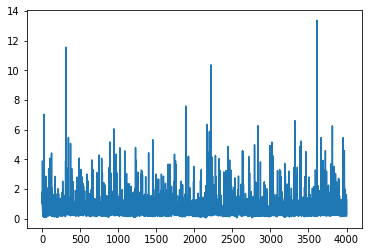

train_motion w teacher epoch 3 / step 255 ---- loss 0.733
train_motion w teacher epoch 3 / step 260 ---- loss 0.501
train_motion w teacher epoch 3 / step 265 ---- loss 0.575
train_motion w teacher epoch 3 / step 270 ---- loss 1.280
train_motion w teacher epoch 3 / step 275 ---- loss 0.658
train_motion w teacher epoch 3 / step 280 ---- loss 0.427
train_motion w teacher epoch 3 / step 285 ---- loss 0.403
train_motion w teacher epoch 3 / step 290 ---- loss 0.345
train_motion w teacher epoch 3 / step 295 ---- loss 1.409
train_motion w teacher epoch 3 / step 300 ---- loss 0.510
train_motion w teacher epoch 3 / step 305 ---- loss 0.928
train_motion w teacher epoch 3 / step 310 ---- loss 0.326
train_motion w teacher epoch 3 / step 315 ---- loss 0.338
train_motion w teacher epoch 3 / step 320 ---- loss 1.131
train_motion w teacher epoch 3 / step 325 ---- loss 0.481
train_motion w teacher epoch 3 / step 330 ---- loss 0.857
train_motion w teacher epoch 3 / step 335 ---- loss 0.767
train_motion w

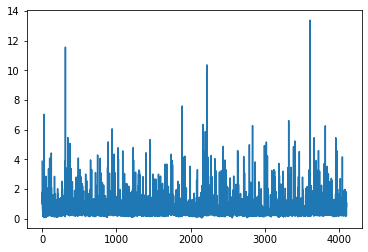

train_motion w teacher epoch 3 / step 355 ---- loss 0.465
train_motion w teacher epoch 3 / step 360 ---- loss 0.431
train_motion w teacher epoch 3 / step 365 ---- loss 0.967
train_motion w teacher epoch 3 / step 370 ---- loss 0.409
train_motion w teacher epoch 3 / step 375 ---- loss 1.674
train_motion w teacher epoch 3 / step 380 ---- loss 0.599
train_motion w teacher epoch 3 / step 385 ---- loss 0.466
train_motion w teacher epoch 3 / step 390 ---- loss 1.390
train_motion w teacher epoch 3 / step 395 ---- loss 0.954
train_motion w teacher epoch 3 / step 400 ---- loss 0.529
train_motion w teacher epoch 3 / step 405 ---- loss 0.667
train_motion w teacher epoch 3 / step 410 ---- loss 0.793
train_motion w teacher epoch 3 / step 415 ---- loss 0.415
train_motion w teacher epoch 3 / step 420 ---- loss 0.308
train_motion w teacher epoch 3 / step 425 ---- loss 0.580
train_motion w teacher epoch 3 / step 430 ---- loss 0.459
train_motion w teacher epoch 3 / step 435 ---- loss 0.354
train_motion w

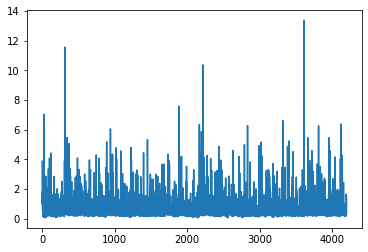

train_motion w teacher epoch 3 / step 455 ---- loss 0.574
train_motion w teacher epoch 3 / step 460 ---- loss 1.483
train_motion w teacher epoch 3 / step 465 ---- loss 2.036
train_motion w teacher epoch 3 / step 470 ---- loss 0.704
train_motion w teacher epoch 3 / step 475 ---- loss 0.835
train_motion w teacher epoch 3 / step 480 ---- loss 0.537
train_motion w teacher epoch 3 / step 485 ---- loss 0.932
train_motion w teacher epoch 3 / step 490 ---- loss 0.484
train_motion w teacher epoch 3 / step 495 ---- loss 0.722
train_motion w teacher epoch 3 / step 500 ---- loss 0.526
train_motion w teacher epoch 3 / step 505 ---- loss 0.761
train_motion w teacher epoch 3 / step 510 ---- loss 0.431
train_motion w teacher epoch 3 / step 515 ---- loss 0.499
train_motion w teacher epoch 3 / step 520 ---- loss 0.405
train_motion w teacher epoch 3 / step 525 ---- loss 0.489
train_motion w teacher epoch 3 / step 530 ---- loss 1.003
train_motion w teacher epoch 3 / step 535 ---- loss 0.335
train_motion w

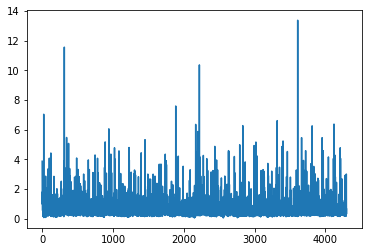

train_motion w teacher epoch 3 / step 555 ---- loss 0.815
train_motion w teacher epoch 3 / step 560 ---- loss 0.932
train_motion w teacher epoch 3 / step 565 ---- loss 0.572
train_motion w teacher epoch 3 / step 570 ---- loss 0.418
train_motion w teacher epoch 3 / step 575 ---- loss 0.448
train_motion w teacher epoch 3 / step 580 ---- loss 0.709
train_motion w teacher epoch 3 / step 585 ---- loss 0.580
train_motion w teacher epoch 3 / step 590 ---- loss 0.413
train_motion w teacher epoch 3 / step 595 ---- loss 0.503
train_motion w teacher epoch 3 / step 600 ---- loss 0.587
train_motion w teacher epoch 3 / step 605 ---- loss 1.221
train_motion w teacher epoch 3 / step 610 ---- loss 0.494
train_motion w teacher epoch 3 / step 615 ---- loss 0.966
train_motion w teacher epoch 3 / step 620 ---- loss 0.594
train_motion w teacher epoch 3 / step 625 ---- loss 0.473
train_motion w teacher epoch 3 / step 630 ---- loss 0.574
train_motion w teacher epoch 3 / step 635 ---- loss 0.553
train_motion w

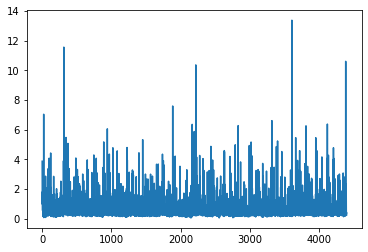

train_motion w teacher epoch 3 / step 655 ---- loss 1.096
train_motion w teacher epoch 3 / step 660 ---- loss 0.453
train_motion w teacher epoch 3 / step 665 ---- loss 0.572
train_motion w teacher epoch 3 / step 670 ---- loss 0.621
train_motion w teacher epoch 3 / step 675 ---- loss 0.648
train_motion w teacher epoch 3 / step 680 ---- loss 1.533
train_motion w teacher epoch 3 / step 685 ---- loss 0.725
train_motion w teacher epoch 3 / step 690 ---- loss 0.730
train_motion w teacher epoch 3 / step 695 ---- loss 0.466
train_motion w teacher epoch 3 / step 700 ---- loss 0.601
train_motion w teacher epoch 3 / step 705 ---- loss 0.535
train_motion w teacher epoch 3 / step 710 ---- loss 0.493
train_motion w teacher epoch 3 / step 715 ---- loss 1.128
train_motion w teacher epoch 3 / step 720 ---- loss 0.731
train_motion w teacher epoch 3 / step 725 ---- loss 0.400
train_motion w teacher epoch 3 / step 730 ---- loss 0.632
train_motion w teacher epoch 3 / step 735 ---- loss 0.284
train_motion w

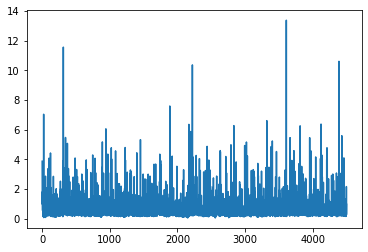

train_motion w teacher epoch 3 / step 755 ---- loss 0.212
train_motion w teacher epoch 3 / step 760 ---- loss 0.527
train_motion w teacher epoch 3 / step 765 ---- loss 0.492
train_motion w teacher epoch 3 / step 770 ---- loss 0.282
train_motion w teacher epoch 3 / step 775 ---- loss 0.374
train_motion w teacher epoch 3 / step 780 ---- loss 0.805
train_motion w teacher epoch 3 / step 785 ---- loss 0.254
train_motion w teacher epoch 3 / step 790 ---- loss 0.438
train_motion w teacher epoch 3 / step 795 ---- loss 0.464
train_motion w teacher epoch 3 / step 800 ---- loss 0.779
train_motion w teacher epoch 3 / step 805 ---- loss 0.367
train_motion w teacher epoch 3 / step 810 ---- loss 0.887
train_motion w teacher epoch 3 / step 815 ---- loss 0.679
train_motion w teacher epoch 3 / step 820 ---- loss 0.467
train_motion w teacher epoch 3 / step 825 ---- loss 0.587
train_motion w teacher epoch 3 / step 830 ---- loss 1.151
train_motion w teacher epoch 3 / step 835 ---- loss 0.807
train_motion w

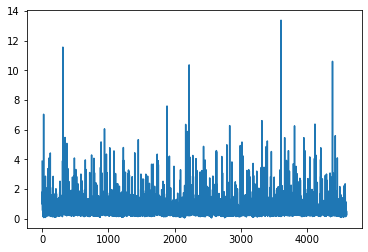

train_motion w teacher epoch 3 / step 855 ---- loss 0.648
train_motion w teacher epoch 3 / step 860 ---- loss 0.437
train_motion w teacher epoch 3 / step 865 ---- loss 1.352
train_motion w teacher epoch 3 / step 870 ---- loss 0.355
train_motion w teacher epoch 3 / step 875 ---- loss 0.555
train_motion w teacher epoch 3 / step 880 ---- loss 0.573
train_motion w teacher epoch 3 / step 885 ---- loss 0.970
train_motion w teacher epoch 3 / step 890 ---- loss 0.445
train_motion w teacher epoch 3 / step 895 ---- loss 0.458
train_motion w teacher epoch 3 / step 900 ---- loss 0.773
train_motion w teacher epoch 3 / step 905 ---- loss 0.616
train_motion w teacher epoch 3 / step 910 ---- loss 0.550
train_motion w teacher epoch 3 / step 915 ---- loss 0.912
train_motion w teacher epoch 3 / step 920 ---- loss 0.667
train_motion w teacher epoch 3 / step 925 ---- loss 0.815
train_motion w teacher epoch 3 / step 930 ---- loss 0.993
train_motion w teacher epoch 3 / step 935 ---- loss 0.391
train_motion w

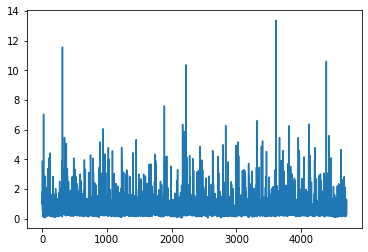

train_motion w teacher epoch 3 / step 955 ---- loss 0.475
train_motion w teacher epoch 3 / step 960 ---- loss 1.213
train_motion w teacher epoch 3 / step 965 ---- loss 0.432
train_motion w teacher epoch 3 / step 970 ---- loss 0.351
train_motion w teacher epoch 3 / step 975 ---- loss 0.690
train_motion w teacher epoch 3 / step 980 ---- loss 0.840
train_motion w teacher epoch 3 / step 985 ---- loss 0.468
train_motion w teacher epoch 3 / step 990 ---- loss 1.047
train_motion w teacher epoch 3 / step 995 ---- loss 0.763
train_motion w teacher epoch 3 / step 1000 ---- loss 0.646
train_motion w teacher epoch 3 / step 1005 ---- loss 0.394
train_motion w teacher epoch 3 / step 1010 ---- loss 0.509
train_motion w teacher epoch 3 / step 1015 ---- loss 0.693
train_motion w teacher epoch 3 / step 1020 ---- loss 0.319
train_motion w teacher epoch 3 / step 1025 ---- loss 0.502
train_motion w teacher epoch 3 / step 1030 ---- loss 1.075
train_motion w teacher epoch 3 / step 1035 ---- loss 0.509
train_

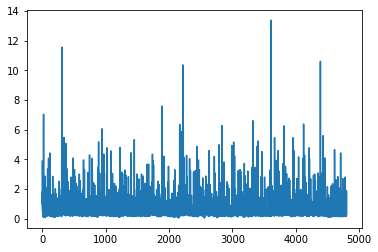

train_motion w teacher epoch 3 / step 1055 ---- loss 0.461
train_motion w teacher epoch 3 / step 1060 ---- loss 0.444
train_motion w teacher epoch 3 / step 1065 ---- loss 0.533
train_motion w teacher epoch 3 / step 1070 ---- loss 0.360
train_motion w teacher epoch 3 / step 1075 ---- loss 0.340
train_motion w teacher epoch 3 / step 1080 ---- loss 0.583
train_motion w teacher epoch 3 / step 1085 ---- loss 0.590
train_motion w teacher epoch 3 / step 1090 ---- loss 1.023
train_motion w teacher epoch 3 / step 1095 ---- loss 1.025
train_motion w teacher epoch 3 / step 1100 ---- loss 0.790
train_motion w teacher epoch 3 / step 1105 ---- loss 0.762
train_motion w teacher epoch 3 / step 1110 ---- loss 0.552
train_motion w teacher epoch 3 / step 1115 ---- loss 0.534
train_motion w teacher epoch 3 / step 1120 ---- loss 0.593
train_motion w teacher epoch 3 / step 1125 ---- loss 0.263
train_motion w teacher epoch 3 / step 1130 ---- loss 1.037
train_motion w teacher epoch 3 / step 1135 ---- loss 0.9

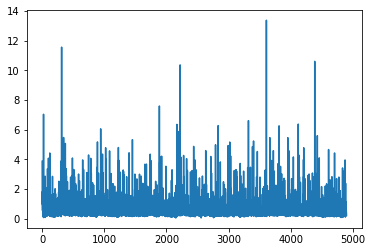

train_motion w teacher epoch 3 / step 1155 ---- loss 0.971
train_motion w teacher epoch 3 / step 1160 ---- loss 0.648
train_motion w teacher epoch 3 / step 1165 ---- loss 0.959
train_motion w teacher epoch 3 / step 1170 ---- loss 0.438
train_motion w teacher epoch 3 / step 1175 ---- loss 0.484
train_motion w teacher epoch 3 / step 1180 ---- loss 0.494
train_motion w teacher epoch 3 / step 1185 ---- loss 0.486
train_motion w teacher epoch 3 / step 1190 ---- loss 0.546
train_motion w teacher epoch 3 / step 1195 ---- loss 0.836
train_motion w teacher epoch 3 / step 1200 ---- loss 0.698
train_motion w teacher epoch 3 / step 1205 ---- loss 0.388
train_motion w teacher epoch 3 / step 1210 ---- loss 0.333
train_motion w teacher epoch 3 / step 1215 ---- loss 1.134
train_motion w teacher epoch 3 / step 1220 ---- loss 0.192
train_motion w teacher epoch 3 / step 1225 ---- loss 1.444
train_motion w teacher epoch 3 / step 1230 ---- loss 0.576
train_motion w teacher epoch 3 / step 1235 ---- loss 0.5

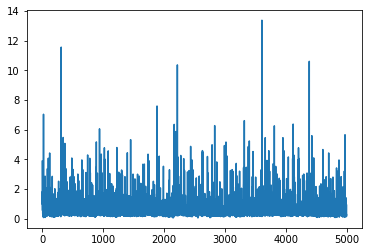

saved model weights to ../checkpoints/bbnet_split4full_rnd0motion_lteacher_ep4.pth


In [11]:
bs = 1
dataloader = torch.utils.data.DataLoader(tdw_dataset, batch_size=bs, shuffle=True)

# bbnet_rnd0 = fprop.BipartiteBootNet(
#     motion_params={'hidden_dim': 64, 'num_iters': 2},
#     mode='train_static').cuda()
# bbnet_rnd0.eval()
# bbnet_rnd0.mode = 'val'
# did_load = bbnet_rnd0.load_state_dict(torch.load(load_path))
# print(did_load)


# static_loss_curve = train_with_teacher(dataloader, bbnet, mclass_net, mode='train_static', 
#                                        load_path=None,
#                                        save_path='../checkpoints/bbnet_split4full_rnd0static_ep20.pth',
#                                        num_steps=25000)
motion_loss_curve = train_with_teacher(dataloader, bbnet, mclass_net, mode='train_motion', 
                                       lr=0.0001, weight_decay=0.0001, teacher_iters=6,
                                       load_path='../checkpoints/bbnet_split4full_rnd0static_ep20.pth',
                                       save_path='../checkpoints/bbnet_split4full_rnd0motion_lteacher_ep4.pth',
#                                        load_path='../checkpoints/bbnet_split4full_rnd0motion12itSeq_ep1.pth', 
#                                        save_path='../checkpoints/bbnet_split4full_rnd0motion12itSeq_ep25.pth',
#                                        load_path='../checkpoints/bbnet_split4full_rnd1static_ep8wd.pth',
#                                        save_path='../checkpoints/bbnet_split4full_rnd1motion_ep4wd.pth',
                                       num_steps=5000)

# selfsup_loss_curve = train_selfsup(dataloader, bbnet, mode='train_static', 
#                                    load_path='../checkpoints/bbnet_split4full_rnd0motion12itSeq_ep25.pth',
#                                    save_path='../checkpoints/bbnet_split4full_rnd1static_ep8wd.pth',
#                                    lr=0.0001, weight_decay=0.0001,
#                                    num_steps=10000)

# selfsup_loss_curve_motion = train_with_teacher(dataloader, bbnet, bbnet_rnd0, 
#                                                out_idx=0, mode='train_motion', 
#                                                num_steps=100)
# selfsup_loss_curve_static = train_selfsup(dataloader, bbnet, mode='train_static', lr=0.0001, num_steps=100)


# selfsup_loss_curve_motion = train_selfsup(dataloader, bbnet, mode='train_motion', lr=1e-6, num_steps=100)

# load_path = '../checkpoints/bbnet_split4full_rnd1motion_ep4wd.pth'
# load_path = '../checkpoints/bbnet_split4full_rnd0static_ep20.pth'

# bbnet.load_state_dict(torch.load(load_path))




In [126]:
!ls ../checkpoints/*bbnet*

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


../checkpoints/bbnet_split4ex10_rnd0motion.pth
../checkpoints/bbnet_split4ex10_rnd0static.pth
../checkpoints/bbnet_split4ex10_rnd1static.pth
../checkpoints/bbnet_split4ex1_demo.pth
../checkpoints/bbnet_split4full_rnd0motion12itSeq_ep1.pth
../checkpoints/bbnet_split4full_rnd0motion12itSeq_ep25.pth
../checkpoints/bbnet_split4full_rnd0motion2it_ep4.pth
../checkpoints/bbnet_split4full_rnd0motion_ep20.pth
../checkpoints/bbnet_split4full_rnd0static_ep20.pth
../checkpoints/bbnet_split4full_rnd1motion_ep4wd.pth
../checkpoints/bbnet_split4full_rnd1static_ep1.pth
../checkpoints/bbnet_split4full_rnd1static_ep8wd.pth


In [13]:
# bbnet.load_state_dict(torch.load('../checkpoints/bbnet_split4full_rnd0static_ep20.pth'))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

In [11]:
prop = fprop.MotionPropagator(
    num_samples=4, 
    confidence_thresh=2,
    num_initial_points=None,
    motion_thresh=0.25,
    radius=1, 
    num_iters=50, 
    update_thresh=0.1).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
ex = 100
bbnet.motion_target_func.motion_sample = True
bbnet.motion_target_func.use_prior = True
bbnet.motion_target_func.confidence_weight = False
# bbnet.motion_model.num_iters = 2
# bbnet.static_model.num_iters = 12

data, preds = eval_step(get_data(tdw_dataset, ex), bbnet, teacher=mclass_net, 
                        iters=6, test_mode=True,
                        mode='train_both')
preds = list(preds)
h, fire = prop(preds[0], preds[1])
preds.insert(2, h)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


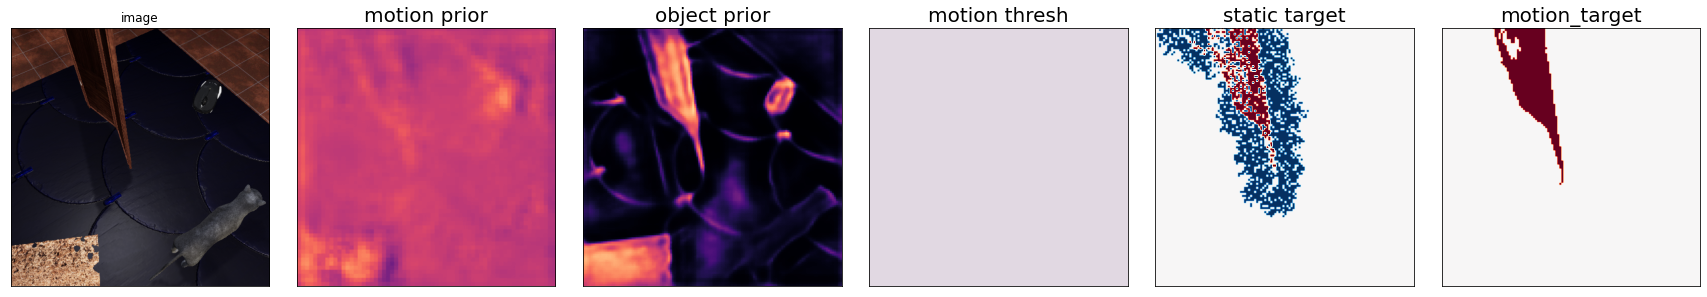

In [31]:
a_ind = 60
# a_ind = -1
fig, axes = plt.subplots(1,6,figsize=(24,4))
vis_utils.imshow(data[0]/255., axes[0])
thresh = 0.9
titles = ['motion prior', 'object prior', 'motion thresh', 'static target', 'motion_target']
axes[0].set_title('image')
axes[0].set_xticks([])
axes[0].set_yticks([])
for i in range(1,6):
    plot = preds[i-1]
    if plot is None:
        plot = torch.ones_like(data[0])
    K = plot.shape[1]
    if K != 1:
        plot = plot[:,a_ind,None]
        
    if i in [1,2]:
        plot = torch.sigmoid(plot)
        vis_utils.imshow(plot, axes[i], cmap='magma', vmin=0, vmax=1)
    
    elif i in [3]:
        plot = (torch.sigmoid(preds[0]) > thresh).float()
#         plot = preds[i]
        vis_utils.imshow(plot, axes[i], cmap='twilight', vmin=0, vmax=2)
    
    if i in [4,5]:
        vis_utils.imshow(plot, axes[i], cmap='RdBu_r', vmin=-1, vmax=1)
    axes[i].set_title(titles[i-1], fontsize=20)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

## Evaluate BBNet -- does it improve on the original motion?

In [15]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                  thingness=False,
                  pred_idx=0,
                  sigmoid=True
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
        
    blob = dataset[ex]
    try:
        img1, img2, flow = blob[:3]
    except:
        img1, img2 = blob[:2]
        flow = torch.zeros_like(img1[:2])
    pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)[pred_idx]
    
    if pred.shape[-2:] != flow.shape[-2:]:
        pred = transforms.Resize(list(flow.shape[-2:]))(pred)
    
    if thingness:
        f = torch.sigmoid if sigmoid else (lambda x:x)
        _seg = lambda x, t: (f(x) > t).cpu().numpy()[0,0]
    else:
        _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = (flow.square().sum(-3).sqrt() > 0.5).cpu().numpy()
#     gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])) if not thingness else tensor_to_arr(torch.sigmoid(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow)) if not thingness else gt_seg
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5, 
                         thingness=False, pred_idx=0, sigmoid=True):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True, 
                                thingness=thingness, pred_idx=pred_idx, sigmoid=sigmoid)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['img1', 'img2', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['image2'])
        ax[2].imshow(return_vals['gt'])
        ax[3].imshow(return_vals['pred'])
        ax[4].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:-1] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 4:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], teacher=None,
                      iters=24, thresh=4, thingness=False, pred_idx=0, sigmoid=True):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, teacher=teacher, ex=ex, iters=iters, thresh=thresh, do_plot=False, 
                             return_errormap=False, thingness=thingness, pred_idx=pred_idx, sigmoid=sigmoid)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(4)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


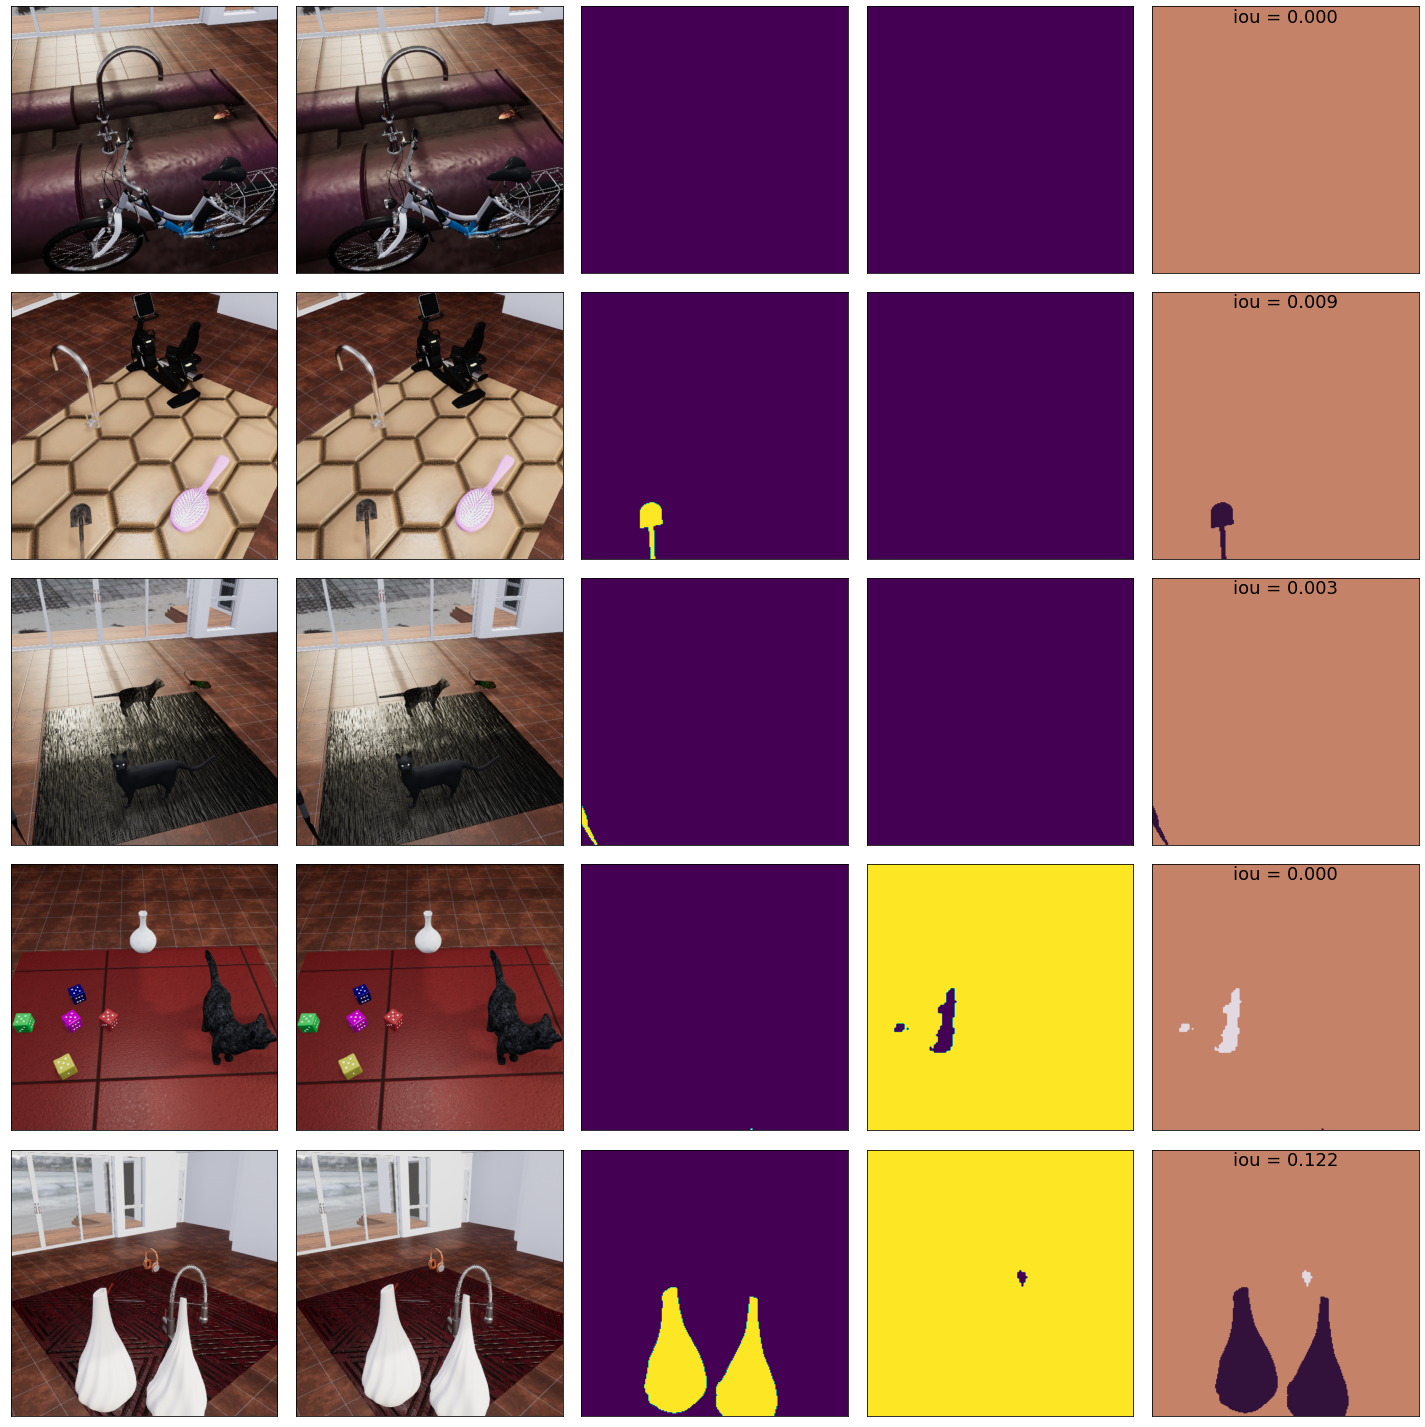

In [16]:
# load_path = '../checkpoints/bbnet_split4full_rnd1static_ep8wd.pth'
# load_path = '../checkpoints/bbnet_split4full_rnd0motion12itSeq_ep25.pth'
# load_path = '../checkpoints/bbnet_split4full_rnd1motion_ep4wd.pth'
load_path = '../checkpoints/bbnet_split4full_rnd0static_ep20.pth'


bbnet.load_state_dict(torch.load(load_path))
bbnet.eval()
bbnet.mode = 'train_both'
thresh = 0.75

tdw_dataset.is_test = True
tdw_dataset.get_backward_frame = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(1,51,10)
visualize_error_maps(bbnet, tdw_dataset, teacher=mclass_net, 
                     examples=examples, thresh=thresh, thingness=True, iters=12, 
                     pred_idx=-1, sigmoid=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier


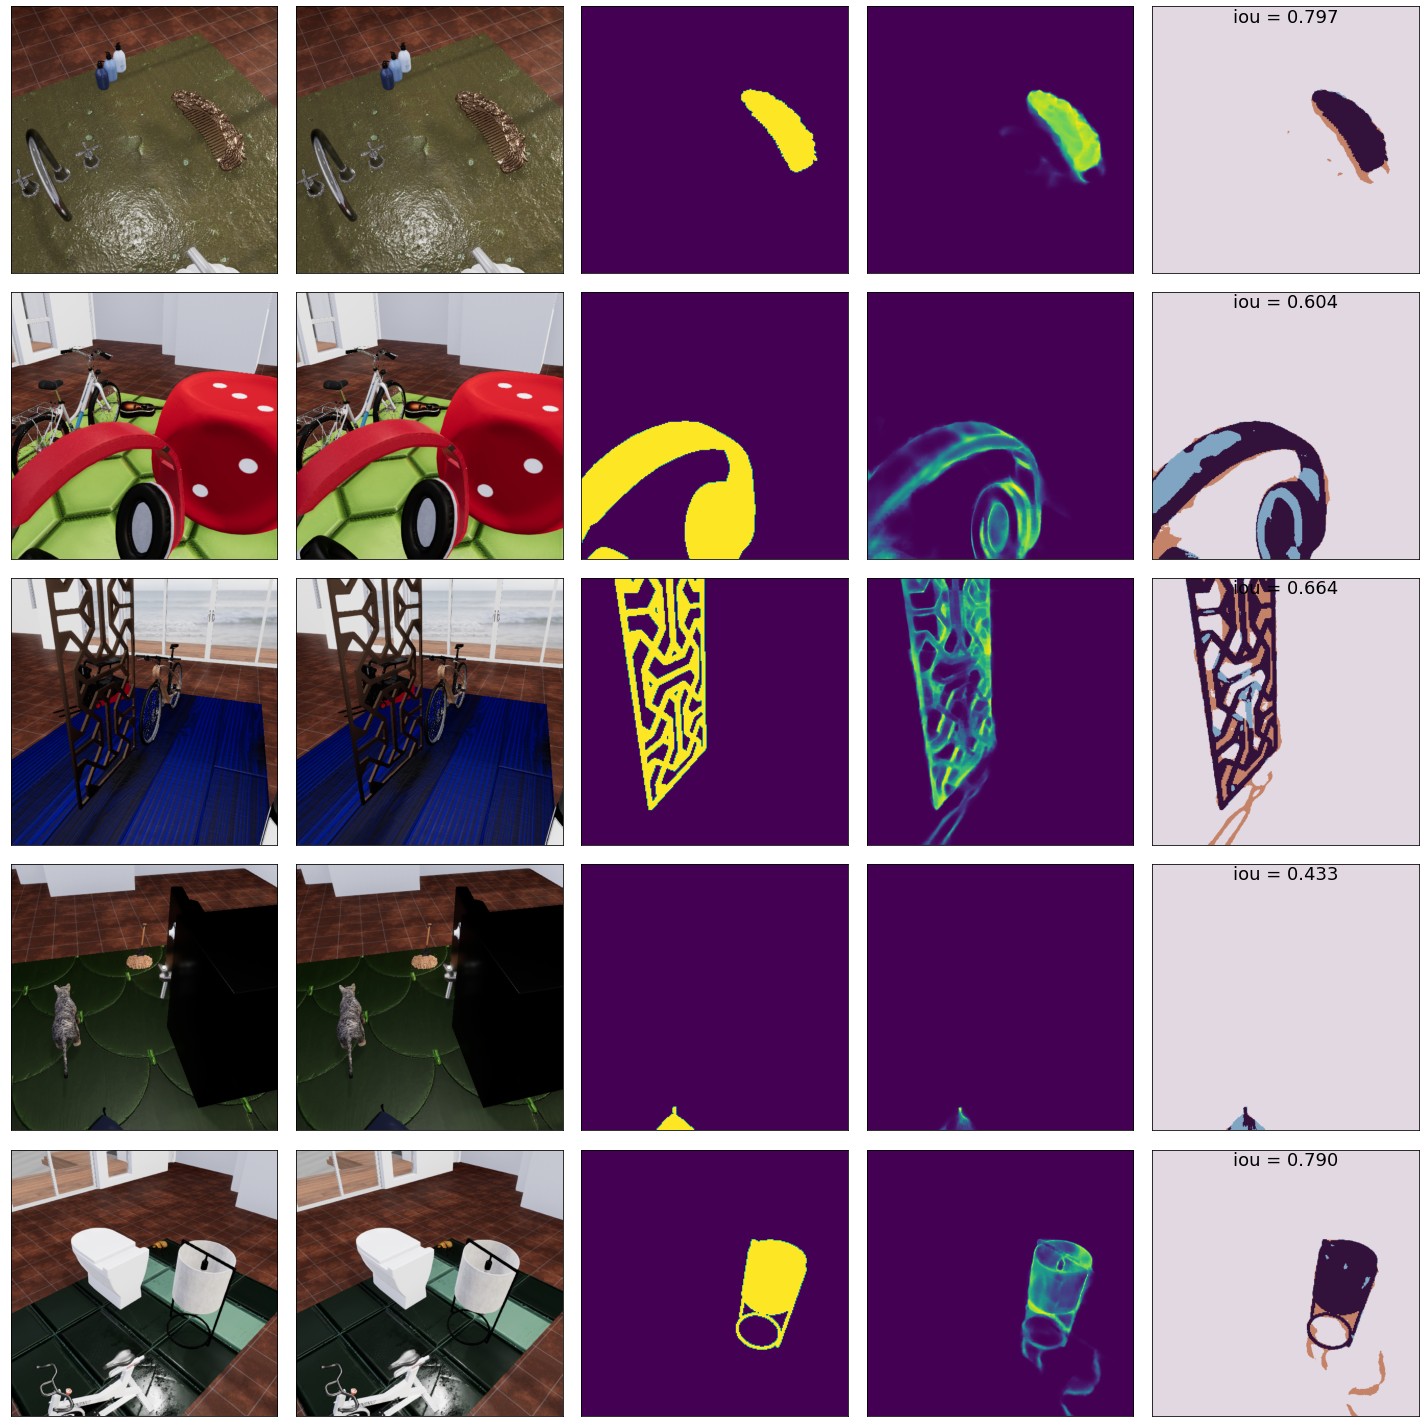

In [121]:
motion_load_path = '35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
mclass_net = load_model(os.path.join('../checkpoints/', motion_load_path),
                        train=False, cuda=True, freeze_bn=False, small=True, gpus=[0])

tdw_dataset.is_test = True
tdw_dataset.get_backward_frame = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(1,51,10)
visualize_error_maps(mclass_net, tdw_dataset, examples=examples, thresh=0.1, thingness=True, iters=24, pred_idx=-1)


In [53]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = range(100)
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True, pred_idx=0)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/100 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/bbnet_split4full_rnd1motion_ep4wd.pth --- val = True, 1250 at thresh = 0.50


 19%|█▉        | 19/100 [00:27<01:35,  1.18s/it]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


({'iou': 0.5863425094951129,
  'precision': 0.7300643828737151,
  'recall': 0.8029173228869498},
 {'iou_isnan': 0.03, 'precision_isnan': 0.03, 'recall_isnan': 0.05})

In [122]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = range(100)
thresh = 0.75

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=12, 
                            thingness=True, pred_idx=0)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/100 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/bbnet_split4full_rnd1static_ep8wd.pth --- val = True, 1250 at thresh = 0.75


 19%|█▉        | 19/100 [00:12<00:52,  1.55it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


({'iou': 0.5770861526574863,
  'precision': 0.8039931034816763,
  'recall': 0.7088331447175372},
 {'iou_isnan': 0.05, 'precision_isnan': 0.05, 'recall_isnan': 0.05})

In [50]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = range(100)
thresh = 0.1

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_load_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=24, 
                            thingness=True, pred_idx=-1)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/100 [00:00<?, ?it/s]

evaluating model --- 35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth --- val = True, 1250 at thresh = 0.10


 19%|█▉        | 19/100 [00:08<00:41,  1.94it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


({'iou': 0.5863711032390673,
  'precision': 0.7510112791957388,
  'recall': 0.7615708789846883},
 {'iou_isnan': 0.03, 'precision_isnan': 0.03, 'recall_isnan': 0.05})